# Russian casualties across regions in the Russia-Ukraine war

The aim of this project is to model the casualties rate (per 100 000 men) in Russia-Ukraine war across regions of Russia based on various socio-economic and demographic indicators. 

This is an abridged version of the project. For many details, please see the full version.

The data on the absolute number of Russian casualties (deaths) in Russia-Ukraine war across regions comes from [Mediazona](https://zona.media/article/2023/07/10/stats). The methodology for counting casualties can be found [here](https://zona.media/article/2023/07/10/stats). It is important to note that not all casualties are accounted for in this record; it is reasonable to assume that the actual number of casualties is 1.5 to 2 times higher. Nonetheless, this is currently the most reliable data available. 

The serious issue concerning the usage of this data in machine learning projects is whether it is representative of the real toll of casualties, specifically whether there is significant selection bias. Unfortunately, we can only speculate on this issue at present. For instance, it is likely that the deaths of Russian soldiers from low populated towns and villages are underrepresented in the Mediazona records. However, to the best of my knowledge, this remains an assumption that has not been rigorously demonstrated so far. Overall, perhaps the best way to frame the following analysis is not in terms of the real death toll of the war on Russian regions but the death toll that has been adequately registered by the best efforts of journalists working on this issue. 

It is important to note that this project is primarily focused on machine learning and does not intend to make any claims beyond the technical aspects of applying machine learning techniques to data on Russian casualties. This project does not pursue any political agenda. With this in mind, it may be interesting to explore how effectively machine learning techniques can model this type of data. 

Additionally, the sample size is small—only 85 regions. Following machine learning practices, this sample is further divided into training and test sets, which exacerbates the sample size issue. For such small samples, simple techniques that generally avoid overfitting are often the most suitable. However, in this project, some relatively sophisticated methods have been employed. It is essential to acknowledge that this is a portfolio project, one of the aims of which is to demonstrate a specific set of skills in machine learning and the ability to work with various models. As a result, some methods were tried and experimented with (especially in the full version of this project) which perhaps would not be employed in "real" ML projects demanding more robust approaches. Nevertheless, relatively sophisticated and arguably less robust methods on small datasets generally succeeded in this particular project, as can be seen in the corresponding sections below. 

The data in socio-economic indicators of Russian regions was obtained from the Federal State Statistics Service site (Rosstat): [rosstat.gov.ru](rosstat.gov.ru). Information regarding payments for signing a contract to serve in the Russian army was sourced from publicly accessible websites, mainly associated with regional authorities. 

## Data Dictionary

In [1]:
import pandas as pd
from pandas import DataFrame

In [2]:
pd.set_option('display.max_colwidth', None)
data_dictionary = pd.read_csv(r"variables.csv")
data_dictionary.set_index("Feature", inplace=True)
data_dictionary

,Description
Feature,
poverty_level_2022,"poverty level, %"
entrepreneurship_income_2023,"income from entrepreneurship in general income structure, %"
social_transfers_income_2023,"income from social transfers in general income structure, %"
mean_salary_2022,mean salary in rubles
median_income_2022,median income in rubles
Gini_coeff_2022,Gini coefficient
decile_coeff_2022,decile coefficient
GRP_pc_2022,gross regional product per capita
unemployment_2022,unemployment rate


## I. Preparation for the analysis: loading data and packages

In [3]:
from pandas import Series
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, LeaveOneOut, KFold
import seaborn as sns
import numpy as np
from sklearn.preprocessing import PowerTransformer, StandardScaler
import matplotlib.pyplot as plt
from scipy.stats import skew, spearmanr, pearsonr, uniform
from sklearn.impute import KNNImputer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import make_scorer, mean_squared_error, median_absolute_error, r2_score
from sklearn.linear_model import HuberRegressor
from sklearn.svm import SVR
import random
import shap

In [4]:
casualties_data = pd.read_csv(r"casualties_data_final.csv", encoding="1251")
casualties_data.head()

,region_in_Russian,region_in_English,poverty_level_2022,entrepreneurship_income_2023,social_transfers_income_2023,mean_salary_2022,median_income_2022,Gini_coeff_2022,decile_coeff_2022,GRP_pc_2022,...,men_share_divorced_2022,share_of_ethnic_russians_2024,men_longevity_2022,men_working_age_rural_2022,crimes_per_10_000_residents_2022,border_with_Ukraine,contract_payment_2023,square_km^2,Caucasus,casualties_mid_july_2025
0,Алтайский край,Altai Krai,13.8,7.9,26.7,39270.4,33688.5,0.371,5.7,433803.0,...,0.112263,95.4,64.13,248139,130.8,0,100000.0,167996,0,2259
1,Амурская область,Amur Oblast,11.9,7.3,19.2,65863.9,76489.2,0.401,6.7,794282.4,...,0.124626,95.2,62.58,74485,161.8,0,200000.0,361908,0,534
2,Архангельская область без авт. округа,Arkhangelsk Oblast,9.2,6.4,25.2,64416.6,30493.9,0.366,5.6,722352.8,...,0.114602,96.3,64.33,62511,119.0,0,100000.0,413103,0,1330
3,Астраханская область,Astrakhan Oblast,12.5,6.5,23.6,47779.9,26790.4,0.352,5.2,800575.6,...,0.123141,67.1,66.83,103052,101.9,0,150000.0,49024,0,1108
4,Белгородская область,Belgorod Oblast,6.0,9.2,20.2,47637.8,29825.3,0.370,5.7,840505.6,...,0.128636,95.3,67.66,160719,71.8,1,100000.0,27134,0,1213


In [5]:
casualties_data.shape

# the original dataset contains 85 observations and 26 features

(85, 26)

In [6]:
casualties_data.info()

# only two features hvae missing values: meadian_income_2022 (8 missing values) and contract_payment_2023 (1 missing value)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 26 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   region_in_Russian                 85 non-null     object 
 1   region_in_English                 85 non-null     object 
 2   poverty_level_2022                85 non-null     float64
 3   entrepreneurship_income_2023      85 non-null     float64
 4   social_transfers_income_2023      85 non-null     float64
 5   mean_salary_2022                  85 non-null     float64
 6   median_income_2022                77 non-null     float64
 7   Gini_coeff_2022                   85 non-null     float64
 8   decile_coeff_2022                 85 non-null     float64
 9   GRP_pc_2022                       85 non-null     float64
 10  unemployment_2022                 85 non-null     float64
 11  men_working_age_total_2022        85 non-null     int64  
 12  relative_c

Let's introduce a new feature that labels the federal district to which each region belongs.. This new feature will be useful for splitting data into train and test samples, as it is comfortable to stratify these samples based on the federal district; this would ensure that train and test samples will be broadly similar to each other.

In addition to the "official" federal districts, I will add a new category called "Cities." This category is important because it includes "cities of federal significance" (Moscow, Saint-Petersburg, and Sevastopol), which are very different from other regions (which include a broad range of settlements, including small towns and villages) in terms of socio-economic and demographic characteristics.

It's important to note that Sevastopol and Crimea are included in the dataset without any political implications. The data on these regions is gathered by Mediazona and can be used for modeling purposes.

In [7]:
# Labeling federal districts + adding a new category - "cities of the federal significance" 

federal_districts = {
    "Southern": ["Adygea", "Crimea Republic", "Kalmykia", "Krasnodar Krai", "Astrakhan Oblast", "Volgograd Oblast", "Rostov Oblast"], 
                     
    "Volga": ["Bashkortostan", "Mari El", "Mordovia", "Tatarstan", "Udmurtia", "Chuvashia", "Kirov Oblast", "Nizhny Novgorod Oblast", "Orenburg Oblast", 
              "Penza Oblast", "Perm Krai", "Samara Oblast", "Saratov Oblast", "Ulyanovsk Oblast"], 
                     
    "Far_Eastern": ["Buryatia", "Sakha", "Primorsky Krai", "Khabarovsk Krai", "Amur Oblast", "Kamchatka Krai", "Magadan Oblast", "Sakhalin Oblast", 
                    "Zabaykalsky Krai", "Jewish Autonomous Oblast", "Chukotka Autonomous Okrug"], 
                     
    "Siberian": ["Altai Republic", "Tuva", "Khakassia", "Krasnoyarsk Krai", "Altai Krai", "Irkutsk Oblast", "Kemerovo Oblast", "Novosibirsk Oblast", 
                 "Omsk Oblast", "Tomsk Oblast"], 
                     
    "North_Caucasian": ["Dagestan", "Ingushetia", "Kabardino-Balkaria", "Karachay-Cherkessia", "North Ossetia–Alania", "Chechnya", "Stavropol Krai"], 
                     
    "Northwestern": ["Karelia", "Komi Republic", "Arkhangelsk Oblast", "Vologda Oblast", "Kaliningrad Oblast", "Leningrad Oblast", "Murmansk Oblast", 
                     "Novgorod Oblast", "Pskov Oblast", "Nenets Autonomous Okrug"], 
                     
    "Central": ["Belgorod Oblast", "Bryansk Oblast", "Vladimir Oblast", "Voronezh Oblast", "Ivanovo Oblast", "Kaluga Oblast", "Kostroma Oblast", 
                "Kursk Oblast", "Lipetsk Oblast", "Moscow Oblast", "Oryol Oblast", "Ryazan Oblast", "Smolensk Oblast", "Tambov Oblast", "Tver Oblast", 
                "Tula Oblast", "Yaroslavl Oblast"],

    "Ural": ["Kurgan Oblast", "Sverdlovsk Oblast", "Tyumen Oblast", "Chelyabinsk Oblast", "Khanty-Mansi Autonomous Okrug", 
             "Yamalo-Nenets Autonomous Okrug"],

    "Cities": ["Moscow", "Saint Petersburg", "Sevastopol"]
    }

# Creating an inversed dictionary for applying a .map() method:
inversed_dict = {j: i for i, group in federal_districts.items() for j in group}

casualties_data["fed_district"] = casualties_data["region_in_English"].map(inversed_dict)

In [8]:
# Splitting the sample with stratification on the federal districts:
train_data, test_data = train_test_split(casualties_data, test_size = 0.3, stratify = casualties_data["fed_district"], random_state=42)

In [9]:
# Checking that the distribution of federal districts across original data and two subsets is similar:

print(
    "Original sample: ", casualties_data["fed_district"].value_counts() / len(casualties_data),
    "\n\nTrain sample: ", train_data["fed_district"].value_counts() / len(train_data),
    "\n\nTest sample: ", test_data["fed_district"].value_counts() / len(test_data)
    )

Original sample:  fed_district
Central            0.200000
Volga              0.164706
Far_Eastern        0.129412
Siberian           0.117647
Northwestern       0.117647
Southern           0.082353
North_Caucasian    0.082353
Ural               0.070588
Cities             0.035294
Name: count, dtype: float64 

Train sample:  fed_district
Central            0.203390
Volga              0.169492
Northwestern       0.118644
Far_Eastern        0.118644
Siberian           0.118644
North_Caucasian    0.084746
Southern           0.084746
Ural               0.067797
Cities             0.033898
Name: count, dtype: float64 

Test sample:  fed_district
Central            0.192308
Far_Eastern        0.153846
Volga              0.153846
Siberian           0.115385
Northwestern       0.115385
Southern           0.076923
North_Caucasian    0.076923
Ural               0.076923
Cities             0.038462
Name: count, dtype: float64


In [10]:
# Checking the sizes of the train and test sets
print(len(train_data), len(test_data))

59 26


From the statistical point of view, the size of the train and test sets are certainly very small, and this will be a vulnerability of the analysis that follows. However, it still can be broadly meaningful if we use simple enough models that do not tend to overfit data on small samples.

In [11]:
# The regions from the train set:
list(train_data["region_in_English"].unique())

['Sevastopol',
 'Tambov Oblast',
 'Ulyanovsk Oblast',
 'Saratov Oblast',
 'Magadan Oblast',
 'Kaluga Oblast',
 'Sverdlovsk Oblast',
 'Rostov Oblast',
 'Krasnoyarsk Krai',
 'Nenets Autonomous Okrug',
 'Adygea',
 'Karachay-Cherkessia',
 'Bryansk Oblast',
 'Perm Krai',
 'Samara Oblast',
 'Kalmykia',
 'Vologda Oblast',
 'Bashkortostan',
 'Kemerovo Oblast',
 'Mari El',
 'Voronezh Oblast',
 'Pskov Oblast',
 'Irkutsk Oblast',
 'Lipetsk Oblast',
 'Karelia',
 'Sakhalin Oblast',
 'Amur Oblast',
 'Moscow Oblast',
 'Novgorod Oblast',
 'Tyumen Oblast',
 'Kostroma Oblast',
 'Tuva',
 'Krasnodar Krai',
 'Ryazan Oblast',
 'Yaroslavl Oblast',
 'Chelyabinsk Oblast',
 'Belgorod Oblast',
 'Chuvashia',
 'Murmansk Oblast',
 'Chechnya',
 'Udmurtia',
 'Dagestan',
 'Mordovia',
 'Zabaykalsky Krai',
 'Kamchatka Krai',
 'Tomsk Oblast',
 'Stavropol Krai',
 'Tatarstan',
 'Tula Oblast',
 'Khabarovsk Krai',
 'Kurgan Oblast',
 'Arkhangelsk Oblast',
 'Saint Petersburg',
 'Omsk Oblast',
 'Vladimir Oblast',
 'Khakassia',


Now we are ready to proceed to the exploratory analysis (of the train set).

## II. Exploratory analysis and feature engineering

In [12]:
# Creating a working copy of the train set
workcopy_train = train_data.copy()
workcopy_train.set_index("region_in_English", inplace=True)

# Creating a target variable - number of casualties per 100 000 of men in the region:
workcopy_train["casualties_rate"] = workcopy_train["casualties_mid_july_2025"] / (workcopy_train["men_working_age_total_2022"] / 100_000)

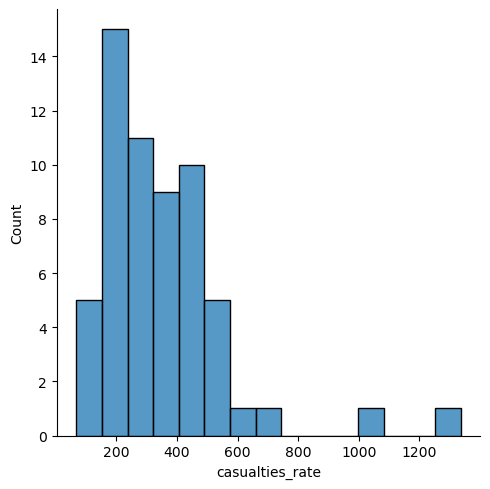

In [13]:
# How casualties rates are distributed across regions

sns.displot(data = workcopy_train, x = "casualties_rate", bins = 15)
plt.show()

# the distribution is visibly right-skewed

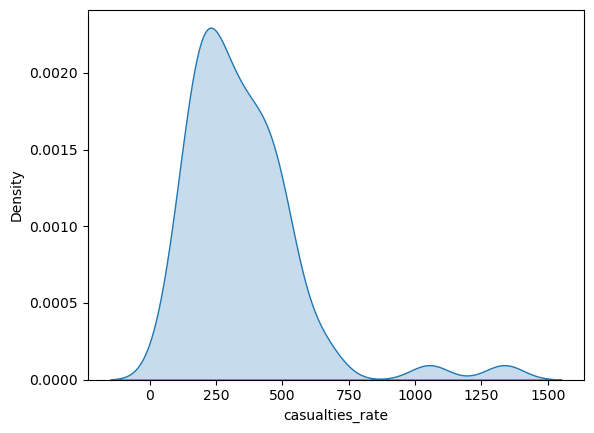

In [14]:
sns.kdeplot(data = workcopy_train, x = "casualties_rate", fill = True, bw_adjust = 0.75)
plt.show()

# The skewness is rather pronounced. There are also some regions with much higher casualty rates (> 1000) than others

Let's create a new version of the target variable to make it more suitable for the analysis that follows; log-transform seems to be a reasonable option here. 

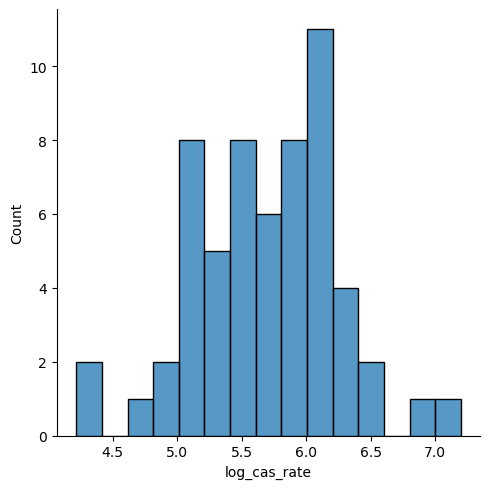

In [15]:
workcopy_train["log_cas_rate"] = np.log(workcopy_train["casualties_rate"])

sns.displot(data = workcopy_train, x = "log_cas_rate", bins = 15)
plt.show()

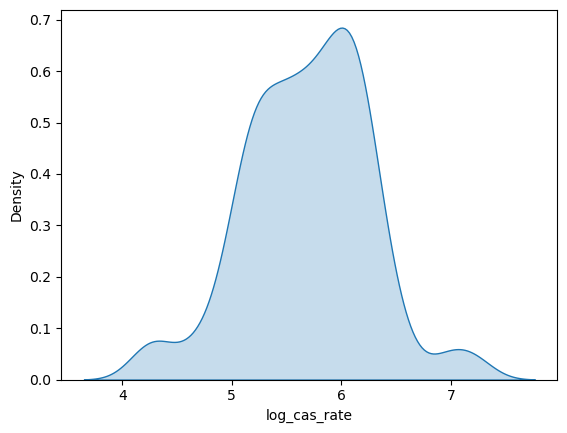

In [16]:
sns.kdeplot(data = workcopy_train, x = "log_cas_rate", fill = True, bw_adjust = 0.75)
plt.show()

The distribution after log-transform is less skewed, but there is still a problem of heavy tails. Perhaps another transformation could help.

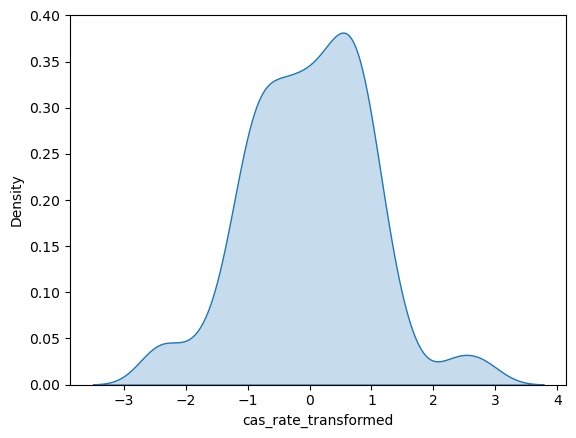

In [17]:
# Applying Yeo-Johnson transformation to the original target variable

cas_rate_transformed = PowerTransformer(method = "yeo-johnson").fit_transform(workcopy_train[["log_cas_rate"]])
cas_rate_transformed  = DataFrame(cas_rate_transformed, columns = ["cas_rate_transformed"])
sns.kdeplot(data = cas_rate_transformed, x = "cas_rate_transformed", fill=True, bw_adjust = 0.75)
plt.show()

Unfortunately, this does not help and heavy tails persist. Together with a small sample size, this deviation from normality is an argument to use robust models in the main part of the analysis.

Now, let's take a closer look at the descriptive statistics of the target variable, both in its original form and after log transformation.

In [18]:
workcopy_train["casualties_rate"].describe()

count      59.000000
mean      346.427757
std       216.125160
min        67.897874
25%       200.339783
50%       301.605167
75%       458.448867
max      1336.278660
Name: casualties_rate, dtype: float64

In [19]:
workcopy_train["log_cas_rate"].describe()

count    59.000000
mean      5.689034
std       0.570998
min       4.218005
25%       5.300013
50%       5.709119
75%       6.127848
max       7.197644
Name: log_cas_rate, dtype: float64

In [20]:
# Regions sorted by casualty rate
workcopy_train["casualties_rate"].sort_values()

region_in_English
Saint Petersburg             67.897874
Chechnya                     76.088439
Kabardino-Balkaria          104.274150
Moscow Oblast               125.504942
Tula Oblast                 142.683495
Karachay-Cherkessia         152.878860
Dagestan                    157.476879
Sevastopol                  161.475819
Ryazan Oblast               173.455913
Khabarovsk Krai             175.919763
Yaroslavl Oblast            177.830468
Adygea                      180.545846
Crimea Republic             181.356547
Rostov Oblast               191.298236
Stavropol Krai              199.947346
Voronezh Oblast             200.732220
Krasnodar Krai              200.973580
Kaluga Oblast               213.108416
Vladimir Oblast             226.240309
Amur Oblast                 228.842758
Lipetsk Oblast              243.777804
Samara Oblast               244.172306
Murmansk Oblast             251.904530
Mordovia                    253.396007
Belgorod Oblast             265.769812
Tambov 

Some interesting patterns can be identified: 

Among the 10 regions with the lowest casualty rates:

1) Three regions—Saint Petersburg, Moscow Oblast, and Sevastopol—are either composed entirely of a single large city, or, in the case of Moscow Oblast, are closely connected to a big city;
2) Four regions (Chechnya, Dagestan, Karachay-Cherkessia, Kabardino-Balkaria) are Caucasus republics (therefore the dummy for Caucasus was included in the dataset); Adygea is on 12th place.

Among the 10 regions with the highest casualty rates:

3) Six regions are situated in Siberia or the Far East;
4) Six regions are national republics.

Observation # 3 suggests that some kind of an indicator of "periphery regions" can be useful for predicting casualty rates. A new feature that reflects this property could be the logarithm of population density (since low population density can be thought of as a proxy for being a "periphery region").

Observation #4 highlights the importance of considering the national composition of Russian regions. However, this observation conflicts with Observation #2, as the Caucasian republics are also categorized as national regions. This indicates that the characteristic of being "national" does not have a straightforward relationship with casualty rates.

5) Buryatia and Tuva "lead" by a wide margin; statistically, they are likely to be outliers. However, we cannot dismiss them as such in a substantive sense, as these high casualty rates may indicate specific combinations of factors—essentially a "perfect storm" leading to intense participation of the local male population in the war.

In [21]:
# Creating a (log-transform) feature of population density as a proxy for the property of being a "periphery region" 
# We add 2 to make all values non-negative for the more comfortable interpretation
workcopy_train["log_density"] =  np.log(workcopy_train['population_2022'] / workcopy_train['square_km^2']) + 2

In [22]:
# Some features in the dataset are not meant to be predictors but serve for creating new, meaningful predictors:

# Adjusted (by the cost of living) mean salary:
workcopy_train["adj_mean_salary"] = workcopy_train["mean_salary_2022"] / workcopy_train["relative_cost_of_living_2022"]
# Adjusted median income:
workcopy_train["adj_median_income"] = workcopy_train["median_income_2022"] / workcopy_train["relative_cost_of_living_2022"]
# Adjusted GRP per capita:
workcopy_train["adj_GRP_pc"] = workcopy_train["GRP_pc_2022"] / workcopy_train["relative_cost_of_living_2022"]
# Share of the male rural population:
workcopy_train["share_rural"] = workcopy_train["men_working_age_rural_2022"] / workcopy_train["men_working_age_total_2022"]
# Share of the male population of working age:
workcopy_train["share_working_age_men"] = workcopy_train["men_working_age_total_2022"] / workcopy_train["population_2022"]

In [23]:
num_feats_ = workcopy_train.select_dtypes(include=[np.number])
list(enumerate(num_feats_))

[(0, 'poverty_level_2022'),
 (1, 'entrepreneurship_income_2023'),
 (2, 'social_transfers_income_2023'),
 (3, 'mean_salary_2022'),
 (4, 'median_income_2022'),
 (5, 'Gini_coeff_2022'),
 (6, 'decile_coeff_2022'),
 (7, 'GRP_pc_2022'),
 (8, 'unemployment_2022'),
 (9, 'men_working_age_total_2022'),
 (10, 'relative_cost_of_living_2022'),
 (11, 'men_higher_educ_2020'),
 (12, 'population_2022'),
 (13, 'men_share_never_married_2022'),
 (14, 'men_share_divorced_2022'),
 (15, 'share_of_ethnic_russians_2024'),
 (16, 'men_longevity_2022'),
 (17, 'men_working_age_rural_2022'),
 (18, 'crimes_per_10_000_residents_2022'),
 (19, 'border_with_Ukraine'),
 (20, 'contract_payment_2023'),
 (21, 'square_km^2'),
 (22, 'Caucasus'),
 (23, 'casualties_mid_july_2025'),
 (24, 'casualties_rate'),
 (25, 'log_cas_rate'),
 (26, 'log_density'),
 (27, 'adj_mean_salary'),
 (28, 'adj_median_income'),
 (29, 'adj_GRP_pc'),
 (30, 'share_rural'),
 (31, 'share_working_age_men')]

In [24]:
# Creating a subset of the train set with numerical predictors for exploratory analysis
num_feats = workcopy_train.select_dtypes(include=[np.number])
num_feats = DataFrame(num_feats, columns = num_feats.columns.to_list()[:3] + 
                      num_feats.columns.to_list()[5:6] + 
                      num_feats.columns.to_list()[8:9] +
                      num_feats.columns.to_list()[13:17] +
                      num_feats.columns.to_list()[18:19] +
                      num_feats.columns.to_list()[20:21] +
                      num_feats.columns.to_list()[26:27] + 
                      num_feats.columns.to_list()[28:], index = num_feats.index)

In [25]:
# descriptive statistics 
pd.set_option("display.max_columns", None)
num_feats.describe()

,poverty_level_2022,entrepreneurship_income_2023,social_transfers_income_2023,Gini_coeff_2022,unemployment_2022,men_share_never_married_2022,men_share_divorced_2022,share_of_ethnic_russians_2024,men_longevity_2022,crimes_per_10_000_residents_2022,contract_payment_2023,log_density,adj_median_income,adj_GRP_pc,share_rural,share_working_age_men
count,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.000000,59.00000,59.000000,59.000000,59.000000,59.000000,53.000000,5.900000e+01,59.000000,59.000000
mean,11.457627,7.877966,22.450847,0.365034,4.666102,0.244386,0.116531,77.50678,66.316441,105.598305,150508.474576,4.832853,33512.017192,8.632825e+05,0.302817,0.296653
std,4.105976,3.766965,4.718503,0.024462,2.307455,0.024945,0.021319,26.45920,2.728155,29.231180,111016.832039,1.733183,11333.611662,1.183924e+06,0.130889,0.012163
min,4.600000,1.600000,12.600000,0.315000,2.000000,0.204041,0.052591,1.20000,61.410000,12.500000,0.000000,0.548833,19846.354167,2.344710e+05,0.000000,0.269712
25%,9.200000,5.500000,19.350000,0.348000,3.300000,0.231237,0.108028,71.30000,64.570000,87.300000,100000.000000,3.600613,26848.064516,4.862946e+05,0.224163,0.288853
50%,10.900000,6.800000,23.200000,0.363000,3.700000,0.240321,0.116964,89.90000,65.890000,104.800000,100000.000000,5.346849,30337.115385,6.350836e+05,0.289401,0.295676
75%,13.500000,9.200000,25.000000,0.378000,5.150000,0.254692,0.128057,94.35000,67.710000,125.350000,200000.000000,5.844522,35051.348315,8.086397e+05,0.383246,0.303140
max,25.900000,23.300000,35.200000,0.441000,12.200000,0.314880,0.163092,96.70000,75.320000,161.800000,600000.000000,10.293322,75668.100000,9.230604e+06,0.615388,0.332536


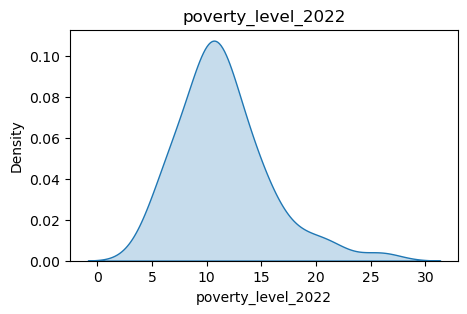

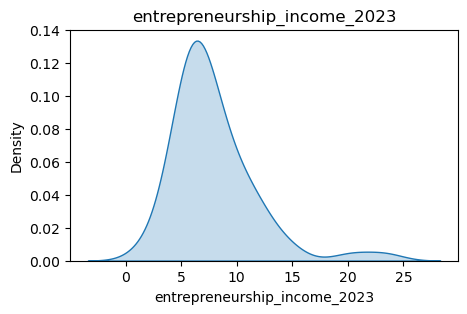

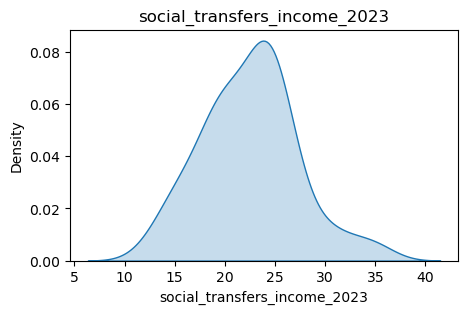

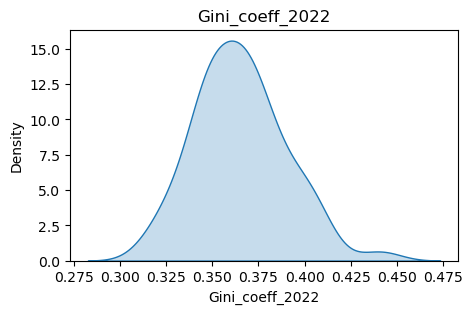

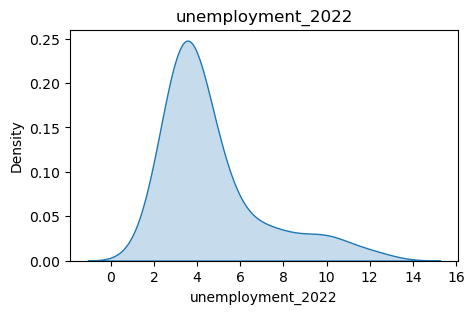

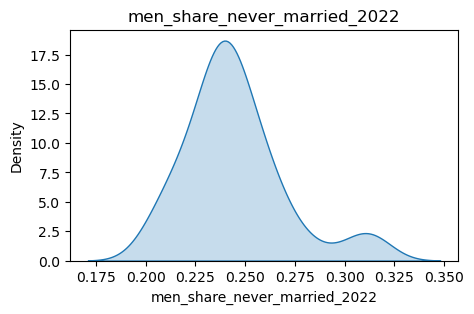

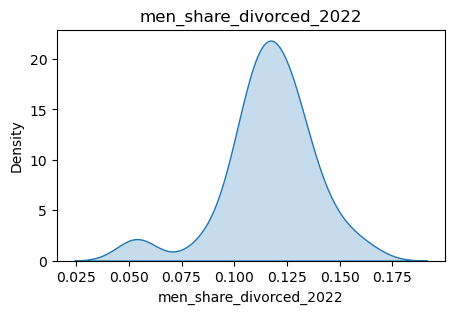

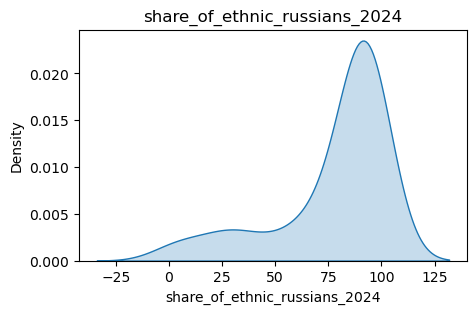

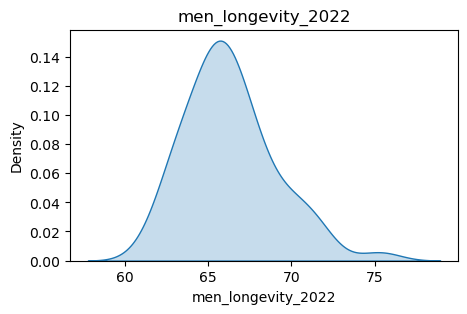

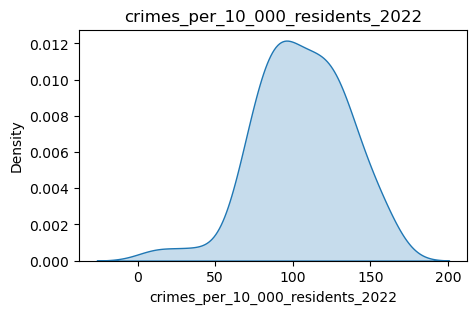

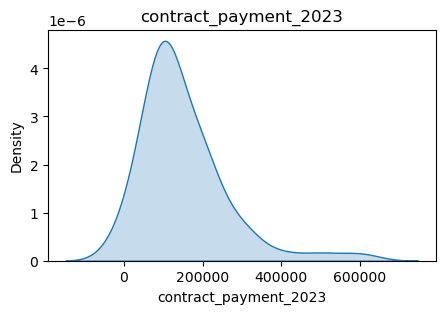

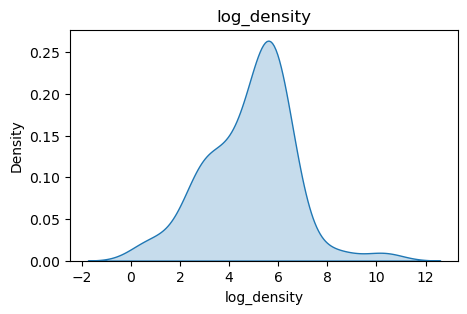

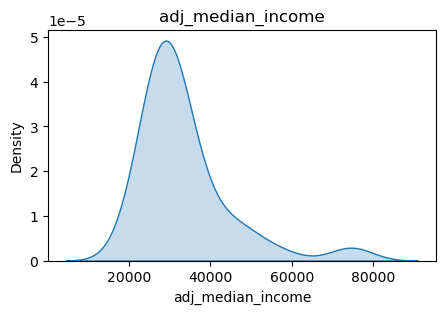

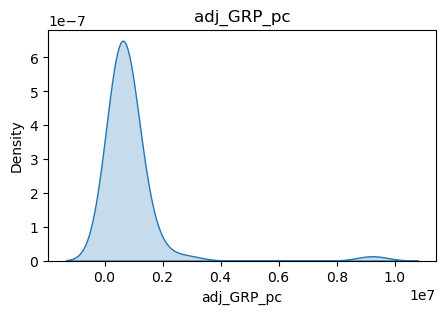

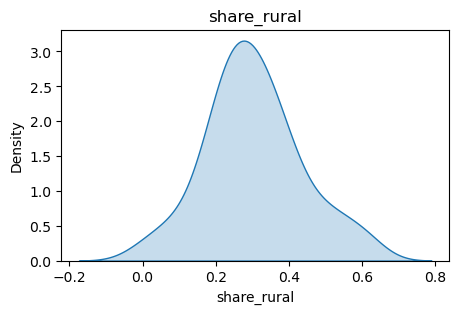

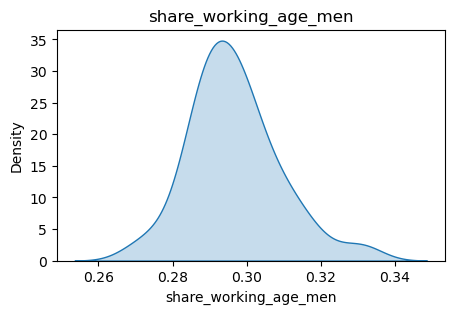

In [26]:
# Kernel denisty plots for potential predictors
for col in num_feats.columns:
    fig, ax = plt.subplots(figsize=(5, 3))
    sns.kdeplot(data = num_feats, x = col, fill=True)
    ax.set_title(col)

plt.show()

The plots indicate that many features exhibit skewness (and we are mostly worried about right-skewness, though left-skewness, if too large, can also be problematic for linear models).  To address this, let's calculate the skewness of the relevant variables.

In [27]:
# Since some vareiables have missing values, imputing is necessary
from sklearn.impute import KNNImputer
imputer = KNNImputer(n_neighbors = 5)

skewness_dict = {}

for col in num_feats.columns:
    imputed = imputer.fit_transform(workcopy_train[[col]]).flatten()
    skewness_dict[col] = skew(imputed).round(3)

skewness_df = DataFrame({"feature": key,
                         "skewness": skewness_dict[key]}
                        for key in skewness_dict.keys()).set_index("feature")

skewness_df

,skewness
feature,
poverty_level_2022,1.073
entrepreneurship_income_2023,1.851
social_transfers_income_2023,0.299
Gini_coeff_2022,0.481
unemployment_2022,1.619
men_share_never_married_2022,1.064
men_share_divorced_2022,-0.919
share_of_ethnic_russians_2024,-1.612
men_longevity_2022,0.798


Heuristically, we can set skewness = 1 as a threshold: if skewness is larger than 1, then transformation is needed.

In [28]:
for feature in skewness_df.index:
    if skewness_df.loc[feature, "skewness"] > 1:
        workcopy_train[f"log_{feature}"] = np.log(workcopy_train[feature] + 1)

In [29]:
# Numbered features
list(enumerate(workcopy_train.columns.to_list()))

[(0, 'region_in_Russian'),
 (1, 'poverty_level_2022'),
 (2, 'entrepreneurship_income_2023'),
 (3, 'social_transfers_income_2023'),
 (4, 'mean_salary_2022'),
 (5, 'median_income_2022'),
 (6, 'Gini_coeff_2022'),
 (7, 'decile_coeff_2022'),
 (8, 'GRP_pc_2022'),
 (9, 'unemployment_2022'),
 (10, 'men_working_age_total_2022'),
 (11, 'relative_cost_of_living_2022'),
 (12, 'men_higher_educ_2020'),
 (13, 'population_2022'),
 (14, 'men_share_never_married_2022'),
 (15, 'men_share_divorced_2022'),
 (16, 'share_of_ethnic_russians_2024'),
 (17, 'men_longevity_2022'),
 (18, 'men_working_age_rural_2022'),
 (19, 'crimes_per_10_000_residents_2022'),
 (20, 'border_with_Ukraine'),
 (21, 'contract_payment_2023'),
 (22, 'square_km^2'),
 (23, 'Caucasus'),
 (24, 'casualties_mid_july_2025'),
 (25, 'fed_district'),
 (26, 'casualties_rate'),
 (27, 'log_cas_rate'),
 (28, 'log_density'),
 (29, 'adj_mean_salary'),
 (30, 'adj_median_income'),
 (31, 'adj_GRP_pc'),
 (32, 'share_rural'),
 (33, 'share_working_age_men'),

In [30]:
# Creating a dataframe for correlation analysis
for_corr_analysis = DataFrame(workcopy_train, 
                              columns = workcopy_train.columns.to_list()[32:] + ['log_density', 'social_transfers_income_2023', "Gini_coeff_2022", 
                                                                                 'men_higher_educ_2020'] + workcopy_train.columns.to_list()[14:20],
                              index = workcopy_train.index)

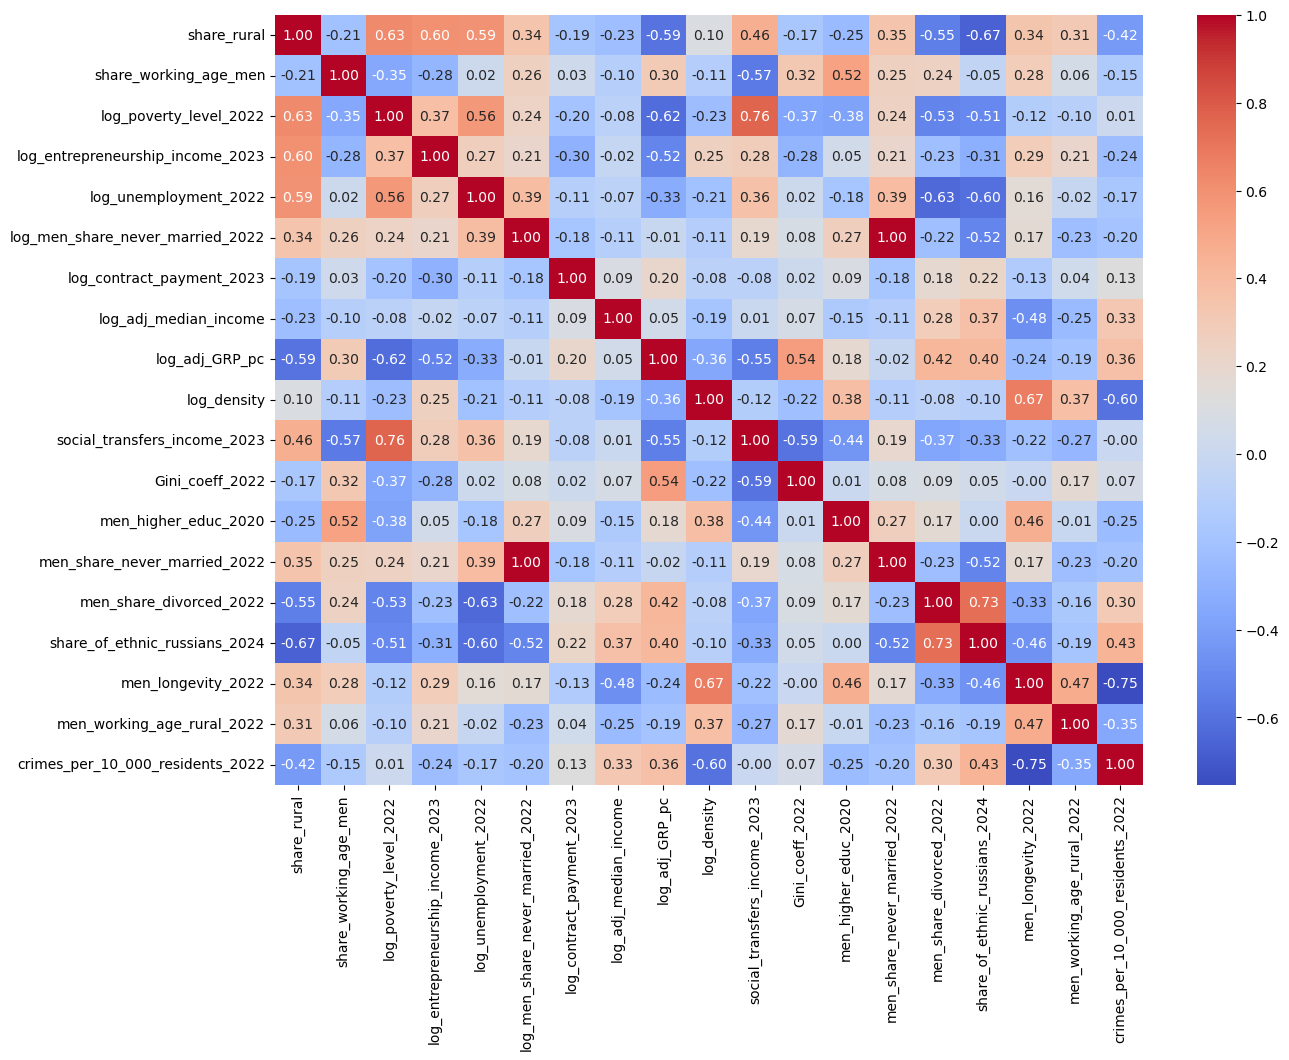

30 pairs with the highest correlation coefficients (by module):


In [31]:
# Correlation matrix heatmap

corr_matrix = for_corr_analysis.corr()

fig, ax = plt.subplots(figsize = (14, 10))

sns.heatmap(corr_matrix, annot = True, cmap = "coolwarm", fmt = ".2f")
plt.show()

# Retrieving 30 pairs with the highest correlation coefficients (by module)

mask = np.triu(np.ones_like(corr_matrix), k = 1).astype(bool)
triang_matrix = corr_matrix.where(mask).stack()
pairwise_corrs = DataFrame(triang_matrix).rename(columns = {0: "correlation_coeff"})
print("30 pairs with the highest correlation coefficients (by module):")
abs(pairwise_corrs["correlation_coeff"].round(3)).sort_values(ascending = False)[:30]

plt.show()

Next, let’s analyze the relationships between our features and the target variable.

In [32]:
# The correlations of the target with the features: Pearson's r and Spearman's r

# Pearson'r r:
num_vars = for_corr_analysis.copy()
num_vars["log_cas_rate"] = workcopy_train["log_cas_rate"].copy()
print("The target and the features: Pearson's r: \n")
print(num_vars.corr()["log_cas_rate"].sort_values()[:-1])

# Spearman's r:
spearmanr_dict = {}
for col in num_vars.columns:
    imputed_col = imputer.fit_transform(num_vars[[col]])
    r, pval = spearmanr(imputed_col, num_vars["log_cas_rate"])
    spearmanr_dict[col] = [np.round(r, 3), np.round(pval, 3)]

spearman_r_df = DataFrame({"feature": key, "Spearman's r": spearmanr_dict[key][0], 
                           "p-value": spearmanr_dict[key][1]} for key in spearmanr_dict.keys())

print("\n\nThe target and the features: Spearman's r: \n")
print(spearman_r_df.sort_values(by = "Spearman's r")[:-1])

The target and the features: Pearson's r: 

men_longevity_2022                 -0.692257
log_density                        -0.654790
men_higher_educ_2020               -0.494112
men_working_age_rural_2022         -0.289501
share_working_age_men              -0.272802
log_entrepreneurship_income_2023   -0.200667
share_rural                        -0.093918
men_share_never_married_2022       -0.091064
log_men_share_never_married_2022   -0.087220
men_share_divorced_2022             0.032640
Gini_coeff_2022                     0.040260
share_of_ethnic_russians_2024       0.040434
log_unemployment_2022               0.042632
log_contract_payment_2023           0.056719
log_adj_median_income               0.098344
log_adj_GRP_pc                      0.213863
log_poverty_level_2022              0.233788
social_transfers_income_2023        0.244141
crimes_per_10_000_residents_2022    0.668125
Name: log_cas_rate, dtype: float64


The target and the features: Spearman's r: 

                   

The correlation coefficients indicate that, among the numeric features, the logarithm of population density, life expectancy for men, and crime rate are the strongest candidates for being important predictors in the following analysis. Let's examine scatter plots.

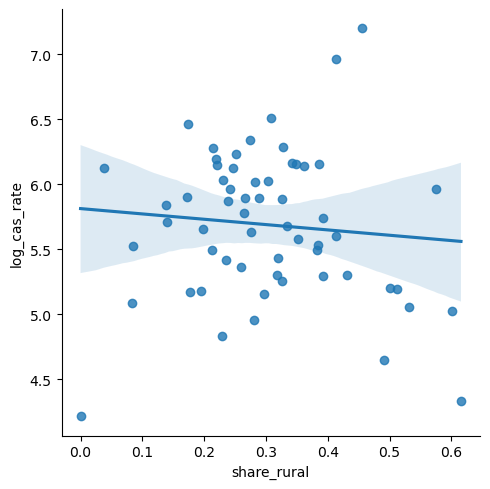

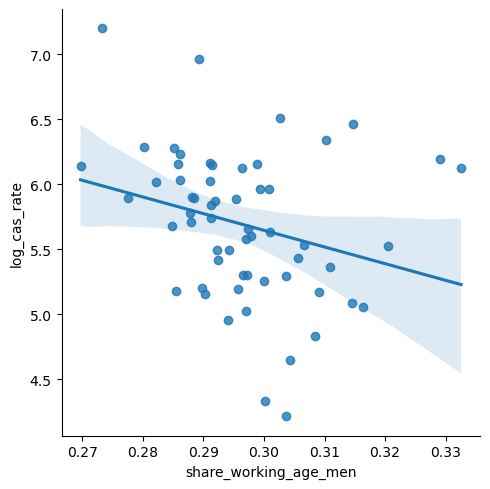

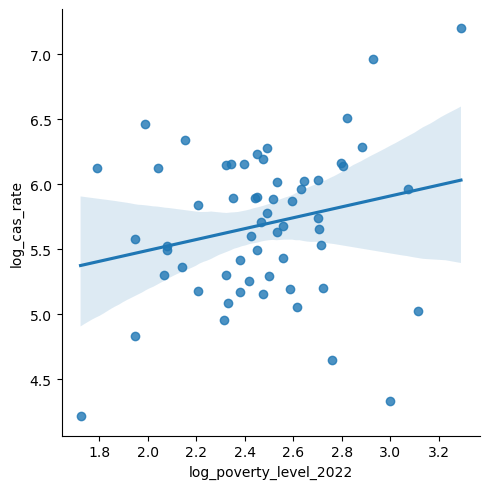

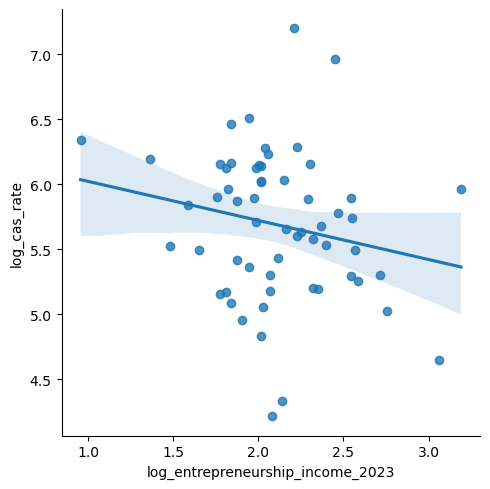

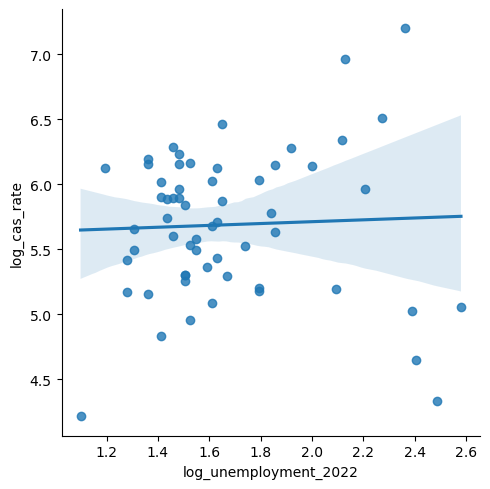

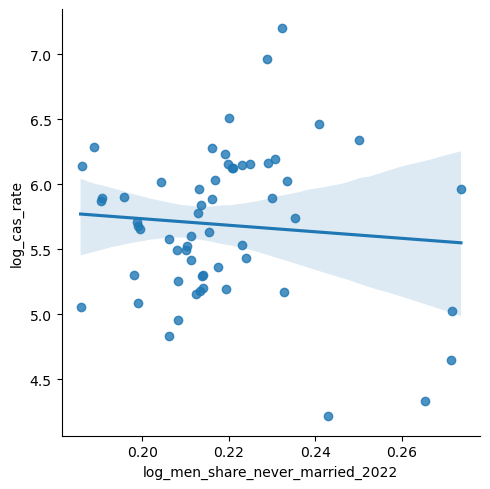

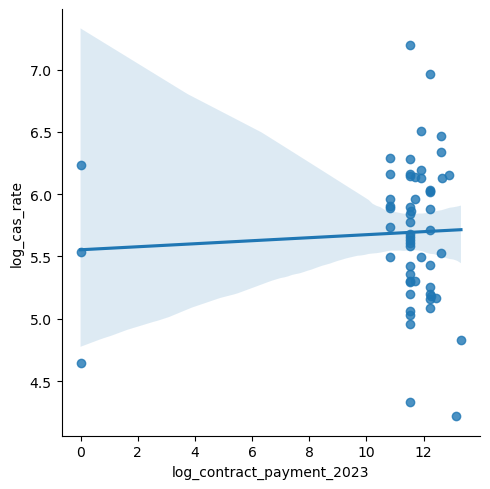

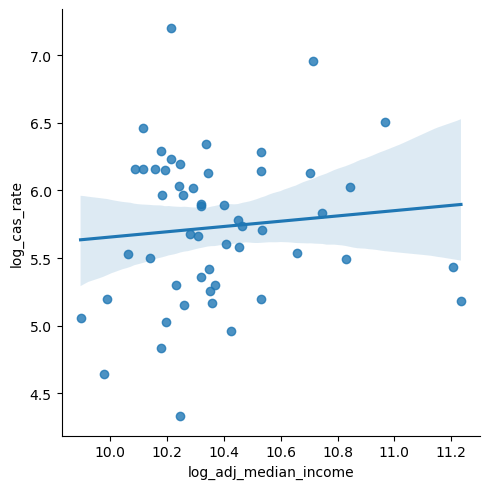

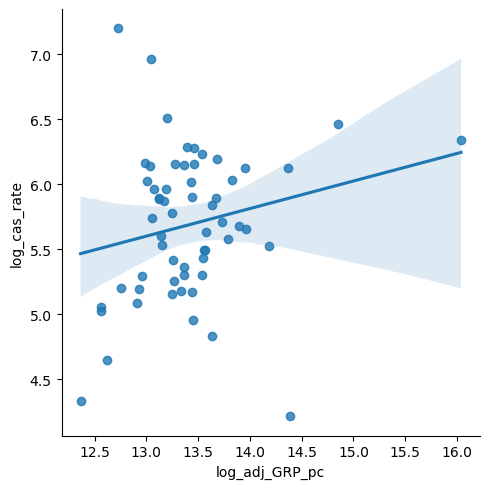

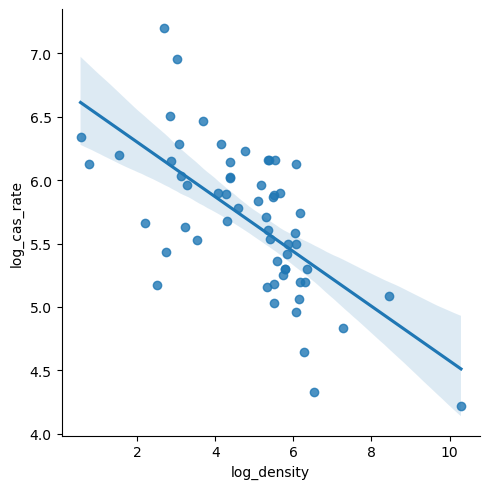

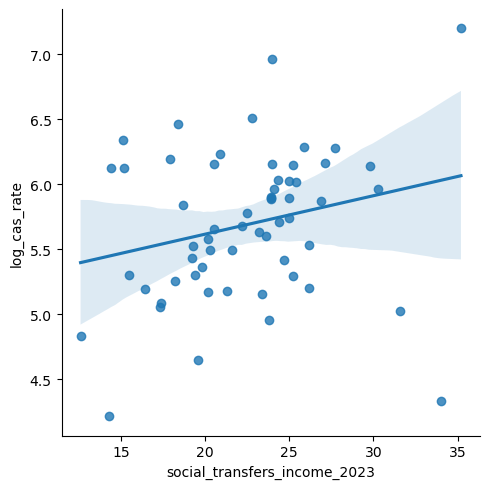

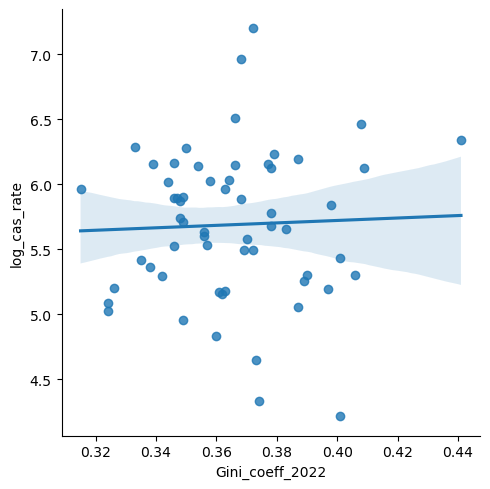

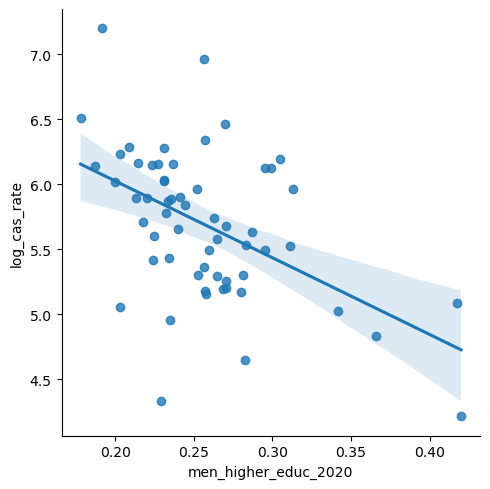

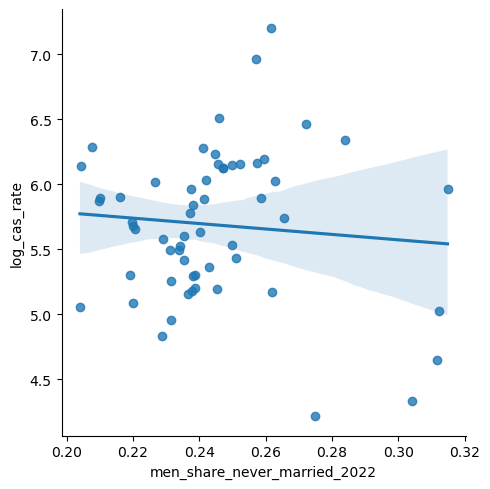

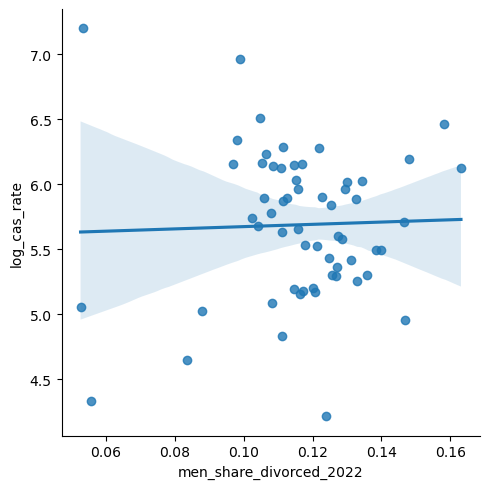

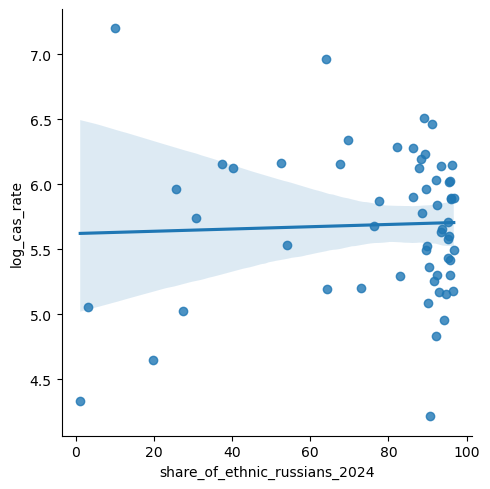

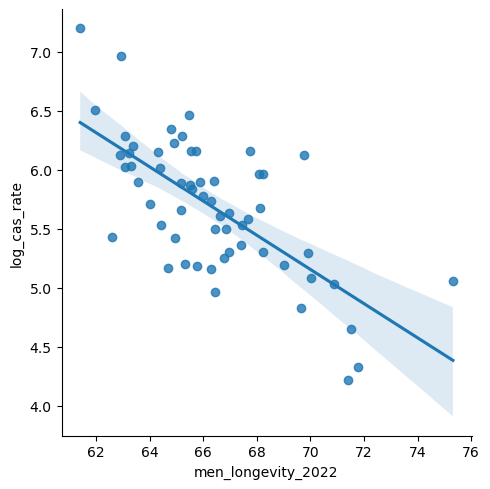

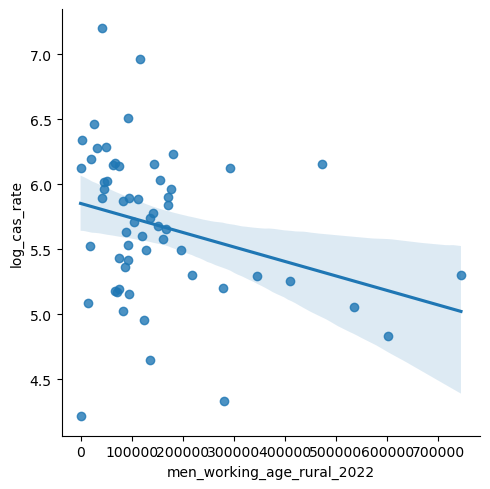

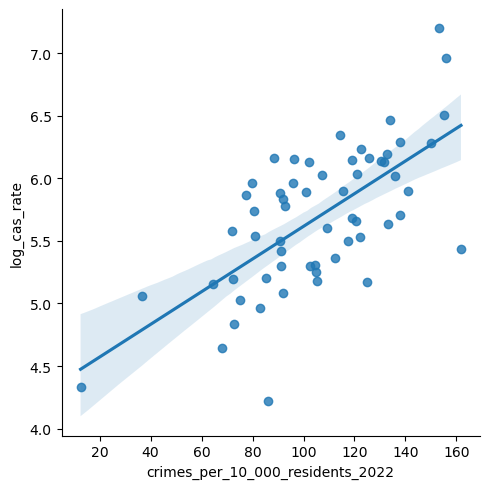

In [33]:
for col in num_vars.columns[:-1]:
    sns.lmplot(data = num_vars, x = col, y = "log_cas_rate")

plt.show()

The visual analysis of the scatter plot corroborates the conclusions from the correlation analysis: the same three features obviously perform better than others.

At the same time, it may be useful to create some meaningful interaction terms which have the potential to push some patterns observed above into greater relief. To highlight some guiding principles behind these interaction terms, it is useful to introduce some conceptual distinctions. The first distinction is concerned with the type of conditions which might facilitate recruitment in the Russian army. The first set of conditions is related to what we may call macro- or "region-level" conditions, which promote higher conscription rates and subsequently lead to increased casualty rates. . I associate this kind of conditions with "structural" explanations of political and bureaucratic nature. In contrast, the second set focuses on micro- or "individual-level" factors, which are tied to socio-economic conditions, as these ultimately manifest in the personal circumstances of individuals.

There are two main channels for recruiting soldiers in the Russian army: 1) coercive mobilization, which began with the announcement of "partial mobilization" in September 2022; and 2) enlistment by contract, which offers substantial payments and high salaries to those who sign. 

Thus, we have two types of facilitating conditions ("region-level" and "individual-level") and two types of recruitment channels (coercive mobilization and volunteer recruitment with very substantial material incentives). Theoretically, these variables can intersect resulting in a 2-by-2 matrix:
1) "region-level" conditions facilitating coercive mobilization;
2) "region-level" conditions facilitating volunteer recruitment with material incentives;
3) "individual-level" conditions facilitating coercive mobilization;
4) "individual-level" conditions facilitating volunteer recruitment with material incentives.

All four conbinations might be important. However, combinations (1) and (4) appear more obvious and heuristically powerful. I will briefly discuss the logic behind them below.

A. "Region-level" conditions facilitating coercive mobilization. 

Certain regions may contribute more soldiers to the Russian army due to their political vulnerability to the wartime political economy logic. It is clear that the federal center (the Russian federal government in the broad sense of the term) exerts pressure on regional authorities regarding soldier recruitment. But it is quite probable that this pressure varies depending on particular contexts. At least three considerations may be relevant in this regard:
1) High mobilization rates create tensions that can have politically undesired consequences. Therefore, active mobilization should be directed towards regions that are either politically insignificant for the federal government or where society lacks the organizational resources to pressure local authorities against mobilization. In this logic, "peripheral" regions distant from major cities like Moscow and St. Petersburg are particularly susceptible to mobilization efforts. The same applies to regions with weak or sparse social networks and low levels of social capital, as these local societies may be unable to resist mobilization (for instance, there were such protests in Dagestan [[1]](https://zona.media/article/2022/09/25/dagestan)).
2) It would be ill-advised to dismiss the possibility that some kind of "imperial" logic is also active in Russian recruitment policies. Some researchers suggest that the Russian government employs "a time-tested imperial tactic of military recruitment from the peripheries" [[Driscoll, Sichinava, Berglund]](https://www.tandfonline.com/doi/full/10.1080/1060586X.2025.2484150). This observation aligns with findings that ethnic minorities are disproportionately hit by this war. [[Vyushkova, Sherkhonov]](https://brill.com/view/journals/inas/25/1/article-p126_11.xml). It implies the possibility of existence of another layer of "periphery" in the Kremlin's possibly "imperial" or quasi-imperial perspective, which includes regions with significant populations of ethnic minorities.
3) Additionally, administrative effectiveness may play a role. All others held equal, it makes sense to assume that sparsely populated regions and rural areas offer fewer opportunities to evade coercive mobilization - in contrast to major cities where individuals have better chances to keep out of sight of military recruitment offices.

These three considerations do not encompass all possible factors, but they do indicate that certain regional characteristics can be significant for analysis. One variable that effectively reflects a substantial share of these characteristics is population density. This variable aligns with the logic of the first consideration, as sparsely populated regions tend to be less politically significant to the federal government and are often located far from Moscow. Additionally, these regions typically lack dense social networks and a vibrant civil society that could withstand mobilization efforts. finally, it is more difficult to avoid the attention of recruitment authorities in sparsely populated areas. 

The second relevant variable is the share of ethnically Russian population (and its inverse - the share of ethnic minorities) which refects the logic behind consideration # 2. 

B. "Individual-level" conditions facilitating volunteer recruitment with material incentives.

In this context, two factors are particularly relevant: the voluntary nature of recruitment and the significant material incentives. The latter suggests that economic conditions may play an important role.  Thus, we may expect that:
1) Mobilization rates may be higher in the regions with higher poverty level.
2) Beyond purely economic factors, a precarious life situation can also influence recruitment. A low level of general well-being may lead individuals to consider signing a contract as a potential escape from difficult circumstances, especially when other options are limited. Crime rates can partially capture this logic, particularly for ex-prisoners who may face challenges reintegrating into civilian life (it's also well known that Russian authorities actively recruit from prisons; this is a consideration that makes crime rates potentially relevant for coercive mobilization from prisons). Life expectancy among men is another variable that can indicate the overall level of well-being.
3) Finally, susceptibility to state propaganda may be another critical factor. The level of education (or, on the region level, the share of the adult male population with higher education) may serve as a proxy for this characteristic.

All these factors may interact with each other creating additional layers of incentives or circumstances facilitating recruitment into the Russian army. It is therefore useful to create some new interaction terms between the variables reflecting these factors, in line with the considerations outlined above.

Thus, we may introduce some interaction terms between our variables reflecting some factors mentioned above.

In this abridged version of the analysis, we will introduce only one interaction term - between the log-transformed population density and (maximum crime rate in the sample minus crime rate in the given region): the higher the value of this interaction term, the lower casualty rate, accoring to our hypotheses.

In the full version of the analysis, additional interaction terms were introduced (but later discarded at the subsequent steps).

In [34]:
# Creating an interaction term described above
workcopy_train["density_crimes"] = workcopy_train["log_density"] * (workcopy_train["crimes_per_10_000_residents_2022"].max() + 1 -
                                                                    workcopy_train["crimes_per_10_000_residents_2022"]) # 6

Skew of crimes_per_10_000_residents_2022 = 0.723


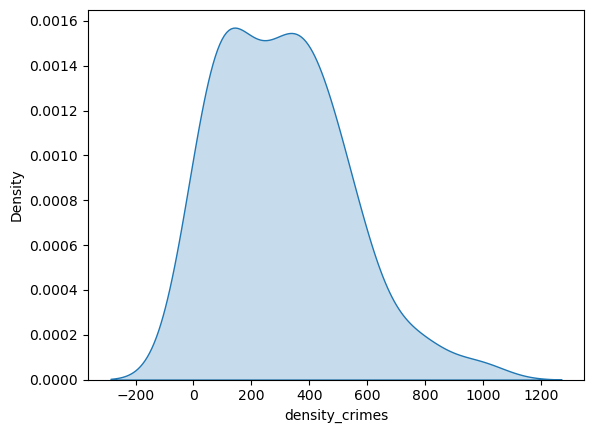

In [35]:
# Checking the distribution of new interaction term

sns.kdeplot(data = workcopy_train, x = "density_crimes", fill = True)
print(f"Skew of {col} = {skew(workcopy_train["density_crimes"]).round(3)}")

plt.show()

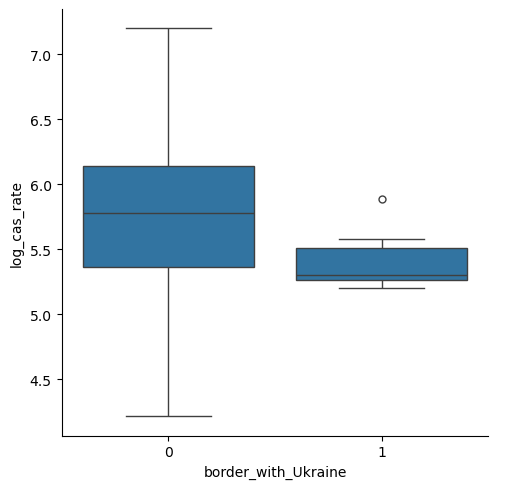

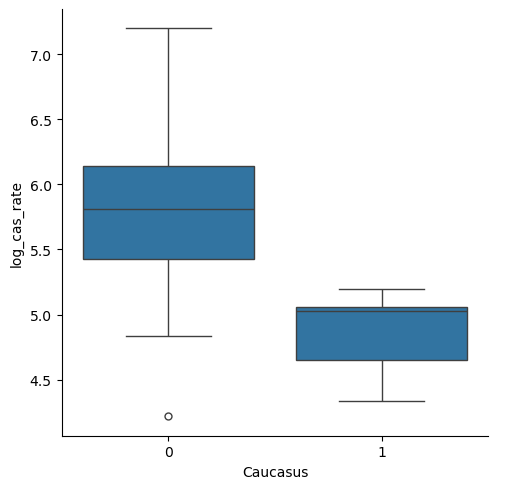

In [36]:
# Creating a dataframe of categorical features and the target
categorical = ['border_with_Ukraine', 'Caucasus']
cat_vars = DataFrame(workcopy_train, columns = categorical + ["log_cas_rate"], index = workcopy_train.index)

# Plotting the relationships between categorical features and the target
for col in cat_vars.columns[:-1]:
    sns.catplot(data = cat_vars, x = col, y = "log_cas_rate", kind = "box")

"Caucasus" appears to be a promising predictor.

In [37]:
# Creating a separate target variable
target = workcopy_train["log_cas_rate"]

## III. Selecting features

For a detailed analysis leading to the selection of the final set of features, please refer to the full version of this project. Below is a brief description of the process.

Our train set comprises 59 observations, and the initial number of potential predictors is 31. The observations-predictors ratio is very low. It is necessary to select predictors. A commonly accepted rule of thumb is that the ideal observations-to-predictors ratio is approximately 10, suggesting we should aim for no more than 6 predictors. 

The following strategy was employed to select the predictors:

1. The initial set of predictors was narrowed down to 10-15 using the SelectKBest method.
2. Some basic models (linear models and decision trees, which were heavily regularized to limit complexity) were implemented to assess the importance of various predictors from the reduced set.
3. Further refinement of the predictor set was achieved through recursive elimination of features with cross-validation (RFECV).
4. As a result of stage 3, four predictors were selected. Several models were tested using these predictors, and the results were not particularly strong (for example, the maximum Pearson’s correlation coefficient between the true and predicted values was less than 0.72).
5. A new set of potentially useful predictors was created. To do this, both SelectKBest and RFECV methods were applied to the 27 predictors that had been previously discarded (31 original predictors minus the 4 that were included in the core dataset). This resulted in the emergence of seven "optional" predictors.
6. Since the goal was to limit the final number of predictors to not more than six, all possible subsets consisting of 0-2 predictors were formed from the seven "optional" predictors. Each of these subsets was combined with the core set of four predictors identified earlier. The outcome of this process was a range of different subsets that included the four core predictors as common elements, along with various combinations of optional predictors.
7. Several models were applied to these subsets, and for each model, the "best" subset was identified.   

## IV. Selecting models for tuning

For a detailed analysis, please refer to the full version of this project.

Initially, a broad set of models were considered, including robust linear models (Ridge, HuberRegression, Lasso, ElasticNet, RANSACRegression), ensemble models (RandomForestRegression, ExtraTreesRegression, AdaBoostRegression, GradientBoostingRegression), a support vector machine model (SVR) and a non-parametric model (KNeighborsRegressor).

During the earlier stages of the analysis, some models were discarded due to their poor performance across all available datasets. For other models, the "best" subsets of predictors were identified. Following this, predictions and residuals of the (yet untuned) models were analyzed, including the correlations between residuals to determine whether any models could complement each other.

As a result, the following models were selected for tuning:

HuberRegressor as the linear model that performs slightly better than Ridge and has marginally less correlated residuals with those of other models;
* ExtraTreesRegressor as the best-performing ensemble model ;
* SVR as the only (and decently performing) support vector machines model;
* KNeighborsRegressor as the only nonparametric model.

## V. Tuning hyperparameters

For a detailed analysis, please refer to the full version of this project.

For each selected model, the best hyperparameters were determined using the RandomizedSearchCV and GridSearchCV algorithms. As before, each model was applied to the subset of predictors on which it demonstrated the best performance. Different metrics were employed, such as RMSE, mean absolute error, median absolute error, explained variance and $R^2$.

The results indicated that the tuned versions of SVR and HuberRegression emerged as the most promising models, outperforming all others in at least one of the metrics.

## VI. Building and choosing the final model

For a detailed analysis, please refer to the full version of this project.

Since there was a hope that models could complement each other (based on how their residuals were correlated), two stacking regressors were tested - one with Ridge as a final estimator and another with GradientBoostingRegressor as a final estimator. However, it turned out that both versions of stacking regressor performed worse than SVR and HuberRegression.

After that, a simple model of aggregation of models were used, with calcuating averages of their predictions, once again in two versions: 1) when only HuberRegression and SVR were used; 2) when all four tuned models were used. However, the results by SVR were still unbeaten.

In general, HuberRegression and SVR emerged as the best-performing models. A comparative analysis of their performance is provided below.

In [38]:
# Subsets of predictors on which models exhibit the best performance (see the full version for details)

svr_subset_feats = ['men_higher_educ_2020',
 'density_crimes',
 'log_density',
 'crimes_per_10_000_residents_2022',
 'Caucasus',
 'share_of_ethnic_russians_2024']

huber_subset_feats = ['men_higher_educ_2020',
 'density_crimes',
 'log_density',
 'crimes_per_10_000_residents_2022',
 'men_longevity_2022',
 'share_of_ethnic_russians_2024']

svr_subset = DataFrame(workcopy_train, columns = svr_subset_feats, index = workcopy_train.index)
huber_subset = DataFrame(workcopy_train, columns = huber_subset_feats, index = workcopy_train.index)

In [39]:
# Initializing tuned models (based on RandomizedSearchCV - see the full version of the project)
preprocessing = StandardScaler()

huber_tuned = make_pipeline(preprocessing, HuberRegressor(alpha = 1.4, epsilon = 271.81))

svr_tuned = Pipeline([
    ("preprocessing", preprocessing), 
    ("svr_version_1", SVR(C = 39.5, epsilon = 0.3, gamma = 0.01, kernel = "rbf"))])

In [40]:
# Creating a Person's r scorer (in addition to rmse and mae as metrics)
def pearson_scorer(x, y):
    r, _ = pearsonr(x, y)
    return r

corr_scorer = make_scorer(pearson_scorer)

# Creating a dictionary of metrics used below
scoring_dict = {"rmse": "neg_root_mean_squared_error", "r": corr_scorer, "mae": "neg_median_absolute_error"}

# Creating a function which would yield a dataframe with the performance of models

def model_performance(models_predictors_dict, scoring, cv):
    models_performance_dict = {}
    for model in models_predictors_dict.keys():
        if scoring == corr_scorer: 
            models_performance_dict[model.steps[-1][1].__class__.__name__] = cross_val_score(model, models_predictors_dict[model], target, 
                                                                                        cv = cv, scoring = scoring).mean().round(3)
            
        else: 
            models_performance_dict[model.steps[-1][1].__class__.__name__] = -cross_val_score(model, models_predictors_dict[model], target, 
                                                                                        cv = cv, scoring = scoring).mean().round(3)
    return models_performance_dict

In [41]:
# Creating a dataframe of cross-validation results for different cross-validation splits

svr = {}
huber = {}

for scoring in scoring_dict.keys():
    svr[scoring] = []
    huber[scoring] = []
    for i in range(2, 21):    
        svr[scoring].append(cross_val_score(svr_tuned, svr_subset, target, cv=i, scoring = scoring_dict[scoring]).mean().round(3))
        huber[scoring].append(cross_val_score(huber_tuned, huber_subset, target, cv=i, scoring = scoring_dict[scoring]).mean().round(3))

cv_scores_df = DataFrame({"num_CVs": np.arange(2, 21), 
                          "svr_rmse": svr["rmse"],
                          "svr_r": svr["r"],
                          "svr_mae": svr["mae"],
                          "huber_rmse": huber["rmse"],
                          "huber_r": huber["r"],
                          "huber_mae": huber["mae"]
                         })

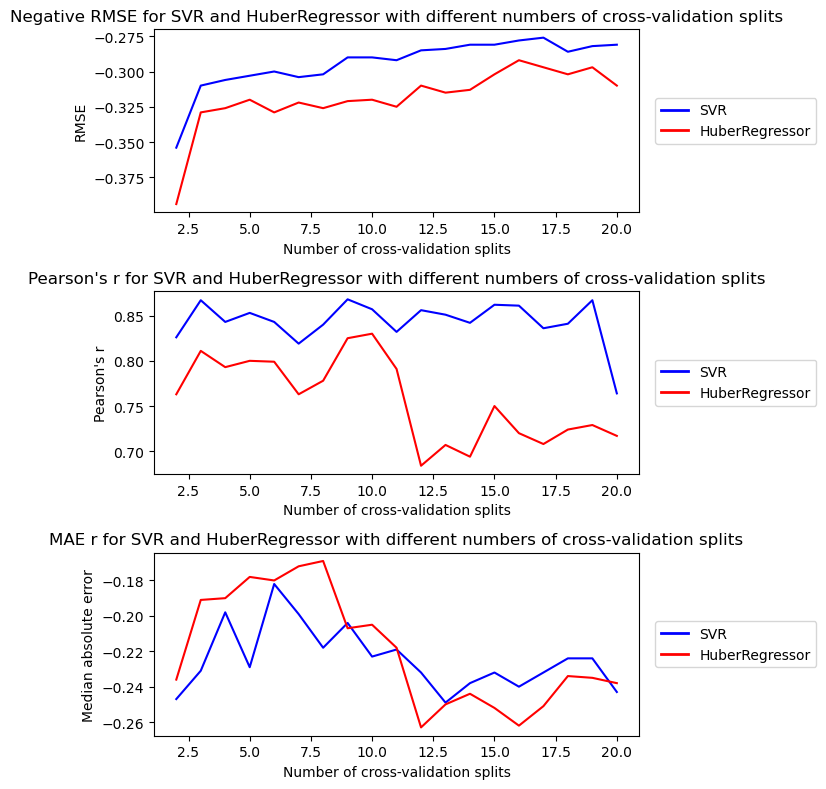

In [42]:
# Plotting rmse scores of SVR and StackingRegressor against different number of cross-validation splits
fig, axs = plt.subplots(3, 1, figsize = (8, 8))

axs[0].plot(cv_scores_df["num_CVs"], cv_scores_df["svr_rmse"], color = "blue")
axs[0].plot(cv_scores_df["num_CVs"], cv_scores_df["huber_rmse"], color = "red")
handles = [plt.Line2D([0], [0], color = color, lw = 2) for color in ["blue", "red"]]
labels = ["SVR", "HuberRegressor"]
axs[0].legend(handles, labels, loc = "center", bbox_to_anchor = (1.2, 0.5))
axs[0].set_title("Negative RMSE for SVR and HuberRegressor with different numbers of cross-validation splits")
axs[0].set_xlabel("Number of cross-validation splits")
axs[0].set_ylabel("RMSE")

axs[1].plot(cv_scores_df["num_CVs"], cv_scores_df["svr_r"], color = "blue")
axs[1].plot(cv_scores_df["num_CVs"], cv_scores_df["huber_r"], color = "red")
handles = [plt.Line2D([0], [0], color = color, lw = 2) for color in ["blue", "red"]]
labels = ["SVR", "HuberRegressor"]
axs[1].legend(handles, labels, loc = "center", bbox_to_anchor = (1.2, 0.5))
axs[1].set_title("Pearson's r for SVR and HuberRegressor with different numbers of cross-validation splits")
axs[1].set_xlabel("Number of cross-validation splits")
axs[1].set_ylabel("Pearson's r")

axs[2].plot(cv_scores_df["num_CVs"], cv_scores_df["svr_mae"], color = "blue")
axs[2].plot(cv_scores_df["num_CVs"], cv_scores_df["huber_mae"], color = "red")
handles = [plt.Line2D([0], [0], color = color, lw = 2) for color in ["blue", "red"]]
labels = ["SVR", "HuberRegressor"]
axs[2].legend(handles, labels, loc = "center", bbox_to_anchor = (1.2, 0.5))
axs[2].set_title("MAE r for SVR and HuberRegressor with different numbers of cross-validation splits")
axs[2].set_xlabel("Number of cross-validation splits")
axs[2].set_ylabel("Median absolute error")

plt.tight_layout()
plt.show()

It is evident that SVR outperforms HuberRegression when comparing rmse and Pearson's r. However, the evaluation of MAE presents a mixed picture: for a small number of cross-validation splits, the Huber Regressor seems to perform better, but this trend generally reverses with an increased number of splits.

Let's examine the performance of models using leave-one-out cross-validation (loocv).

In [43]:
# Since the results of loocv are identical across mae and rmse if models and data stay the same, we may use only one metrics

loocv = LeaveOneOut()

best_models = [svr_tuned, huber_tuned]

print("The results of the best models on leave-one-out cross-validation: \n")
for model in best_models:
    if model == huber_tuned:
        print(f"\n{model.steps[-1][1].__class__.__name__}: \n"
          "Average rmse = ",
          f"{-cross_val_score(model, huber_subset, target, cv = loocv, scoring = "neg_root_mean_squared_error").mean().round(3)}")
    if model == svr_tuned:
        print(f"{model.steps[-1][1].__class__.__name__}: \n"
          "Average rmse = ",
          f"{-cross_val_score(model, svr_subset, target, cv = loocv, scoring = "neg_root_mean_squared_error").mean().round(3)}")

The results of the best models on leave-one-out cross-validation: 

SVR: 
Average rmse =  0.249

HuberRegressor: 
Average rmse =  0.261


Once again, SVR outperforms HuberRegression. Different tests suggest that this is our best model.

To more reliably evaluate how well it generalizes, we may employ nested cross-validation. 

In [44]:
# Creating function for nested cross-validation

def nested_cv(model, param_distribs, scoring, predictors_set):
    model_ = make_pipeline(preprocessing, model)

    outer_cv = KFold(n_splits = 5, shuffle = True, random_state = 42)
    inner_cv = KFold(n_splits = 5, shuffle = True, random_state = 41)

    rand_search = RandomizedSearchCV(model_, param_distributions = param_distribs, n_iter=200, 
                                        scoring = "neg_root_mean_squared_error", cv = inner_cv, random_state=42)

    if scoring == corr_scorer or scoring == "r2":
        nested_cv_results = np.round(cross_val_score(rand_search, predictors_set, target, cv = outer_cv, scoring = scoring), 3)
        
    else:
        nested_cv_results = np.round(-cross_val_score(rand_search, predictors_set, target, cv = outer_cv, scoring = scoring), 3)
        

    print(f"Nested cross-validation scores: {nested_cv_results};\nmean = {nested_cv_results.mean().round(3)};"
          f"\nstandard deviation = {nested_cv_results.std().round(3)}")

In [45]:
model = SVR()
param_distribs = [{"svr__kernel": ["linear", "poly", "rbf", "sigmoid"], 
                          "svr__gamma": ["scale", "auto", 0.01, 0.1, 0.5], "svr__C": uniform(0.01, 99.9),
                         "svr__epsilon": uniform(0.01, 0.99)}]

# Nested cross-validation with different metrics
print("RMSE as a metric:")
nested_cv(model = model, param_distribs = param_distribs, scoring = "neg_root_mean_squared_error", predictors_set = svr_subset)
print("\nPearson's r as a metric:")
nested_cv(model = model, param_distribs = param_distribs, scoring = corr_scorer, predictors_set = svr_subset)
print("\nMedian absolute error as a metric:")
nested_cv(model = model, param_distribs = param_distribs, scoring = "neg_median_absolute_error", predictors_set = svr_subset)
print("\nR squared as a metric:")
nested_cv(model = model, param_distribs = param_distribs, scoring = "r2", predictors_set = svr_subset)

RMSE as a metric:
Nested cross-validation scores: [0.415 0.244 0.341 0.282 0.374];
mean = 0.331;
standard deviation = 0.062

Pearson's r as a metric:
Nested cross-validation scores: [0.632 0.903 0.871 0.914 0.719];
mean = 0.808;
standard deviation = 0.112

Median absolute error as a metric:
Nested cross-validation scores: [0.372 0.211 0.173 0.2   0.179];
mean = 0.227;
standard deviation = 0.074

R squared as a metric:
Nested cross-validation scores: [0.364 0.685 0.676 0.736 0.428];
mean = 0.578;
standard deviation = 0.151


As expected, the results are somewhat worse than those from non-nested cross-validation, but Pearson's r higher than 0.8 is still a decent result.

Finally, we can proceed to the test set.

## VII. Measuring the performance of the best model on the test set

In [46]:
# Creating necessary features in the test set
workcopy_test = test_data.copy()
workcopy_test.set_index("region_in_English", inplace = True)

workcopy_test["log_density"] =  np.log(workcopy_test['population_2022'] / workcopy_test['square_km^2']) + 2

workcopy_test["density_crimes"] = workcopy_test["log_density"] * (workcopy_test["crimes_per_10_000_residents_2022"].max() + 1 -
                                                                    workcopy_test["crimes_per_10_000_residents_2022"]) 

# Creating a dataframe of predictors from the test set
predictors_fin_test = DataFrame(workcopy_test, columns = svr_subset.columns, index = workcopy_test.index)
predictors_fin_test.head()

,men_higher_educ_2020,density_crimes,log_density,crimes_per_10_000_residents_2022,Caucasus,share_of_ethnic_russians_2024
region_in_English,,,,,,
Smolensk Oblast,0.241810,199.109672,4.880139,121.8,0,94.7
Volgograd Oblast,0.238391,251.686397,5.094866,113.2,0,92.5
Ingushetia,0.189997,920.635725,7.098194,32.9,1,0.7
Leningrad Oblast,0.256299,259.744236,5.174188,112.4,0,93.7
Jewish Autonomous Oblast,0.187286,23.234327,3.416813,155.8,0,95.7


In [47]:
# Fitting the best model on the train set
svr_tuned.fit(svr_subset, target)

,steps,"[('preprocessing', ...), ('svr_version_1', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,kernel,'rbf'
,degree,3
,gamma,0.01
,coef0,0.0


In [48]:
# Predicting the values of the dependent variable for the test set
final_predictions_test = svr_tuned.predict(predictors_fin_test)

# Converting log-transformed predicted values into the original scale
final_predictions_orig = np.exp(final_predictions_test)

# Calculating casualties per 100 000 men for the test set
workcopy_test["casualties_rate"] = workcopy_test["casualties_mid_july_2025"] / (workcopy_test["men_working_age_total_2022"] / 100_000)

# Creating a dataframe with the true and predicted values of the dependent variable for the test set
true_and_predicted = DataFrame(workcopy_test, columns = ["casualties_rate"], index = predictors_fin_test.index)
true_and_predicted["predicted_orig_scale"] = final_predictions_orig
true_and_predicted["log_casualties_rate"] = np.log(workcopy_test["casualties_rate"])
true_and_predicted["log_predicted"] = final_predictions_test

In [49]:
# Let's examine the results for the test set
true_and_predicted

,casualties_rate,predicted_orig_scale,log_casualties_rate,log_predicted
region_in_English,,,,
Smolensk Oblast,171.797143,319.354847,5.146314,5.766303
Volgograd Oblast,301.742596,311.244985,5.709574,5.740580
Ingushetia,96.118749,103.175102,4.565584,4.636428
Leningrad Oblast,165.544454,289.149763,5.109240,5.666945
Jewish Autonomous Oblast,255.532842,432.164351,5.543351,6.068806
Moscow,36.428182,84.791545,3.595343,4.440196
Altai Republic,960.488604,835.482995,6.867442,6.728010
Yamalo-Nenets Autonomous Okrug,321.938932,381.029003,5.774362,5.942875
Oryol Oblast,289.058266,227.598222,5.666628,5.427582


In [50]:
# Assesing model's performance for the test set
print(f"Rmse for the test set = {np.round(mean_squared_error(true_and_predicted["log_casualties_rate"], 
                                                             true_and_predicted["log_predicted"])**(0.5), 3)}")

print(f"Pearson's r for the test set (log-transformed values) = "
      f"{true_and_predicted["log_casualties_rate"].corr(true_and_predicted["log_predicted"]).round(3)}")

print(f"Pearson's r for the test set (original scale) = "
      f"{true_and_predicted["casualties_rate"].corr(true_and_predicted["predicted_orig_scale"]).round(3)}")

print(f"MAE for the test set = {np.round(median_absolute_error(true_and_predicted["log_casualties_rate"], 
                                                             true_and_predicted["log_predicted"]), 3)}")
print(f"R squared for the test set = {np.round(r2_score(true_and_predicted["log_casualties_rate"], 
                                                             true_and_predicted["log_predicted"]), 3)}")

Rmse for the test set = 0.402
Pearson's r for the test set (log-transformed values) = 0.776
Pearson's r for the test set (original scale) = 0.755
MAE for the test set = 0.216
R squared for the test set = 0.597


As expected, the results for the test set are somewhat worse compared to the training set for most metrics; however, the decrease in quality is not dramatic. In fact, Pearson's r higher than 0.75 can be considered a good result given our noisy dataset and very low sample size, where potential outliers can have a significant impact. Interestingly, the results for median absolute error and $R^2$ on the test set are even better than that observed during nested cross-validation on the training set. This further supports the hypothesis that we have avoided overfitting the training set and that our model generalizes quite well.

Let’s check for any influential outliers.

In [51]:
# Creating a function for calculating metrics with leaving one region out of sample
def leave_one_out_metrics(y_true, y_pred, metrics):
    n = len(y_true)
    res = np.zeros(n)
    for i in range(n):
        mask = (np.arange(n)!= i)
        if metrics == pearsonr:
            res[i], _ = metrics(y_true[mask], y_pred[mask])
        else:
            res[i] = metrics(y_true[mask], y_pred[mask])
    return res

In [52]:
#Creating a dataframe with quality metrics with each region left out at a time
loo_results = DataFrame({"region": true_and_predicted.index,
           "corr_without_region": leave_one_out_metrics(true_and_predicted["casualties_rate"], true_and_predicted["predicted_orig_scale"], pearsonr),
                 "mse_without_region": leave_one_out_metrics(true_and_predicted["log_casualties_rate"], true_and_predicted["log_predicted"], 
                                                              mean_squared_error)}).set_index("region")

# Converting mse metrics into rmse metrics for comparability with the previous analysis
loo_results["rmse_without_region"] = loo_results["mse_without_region"]**(0.5)

# Printing sorted results
print(f"Sorted by Pearson's r:\n{loo_results["corr_without_region"].sort_values()}\n\n")
print(f"Sorted by rmse:\n{loo_results["rmse_without_region"].sort_values()}")

Sorted by Pearson's r:
region
Altai Republic                    0.641497
Chukotka Autonomous Okrug         0.722880
Moscow                            0.730038
Ingushetia                        0.736575
Komi Republic                     0.747849
Nizhny Novgorod Oblast            0.750664
Penza Oblast                      0.752951
Kursk Oblast                      0.753180
Novosibirsk Oblast                0.754224
Volgograd Oblast                  0.754730
Astrakhan Oblast                  0.755052
Oryol Oblast                      0.755147
Altai Krai                        0.755219
Primorsky Krai                    0.755299
Yamalo-Nenets Autonomous Okrug    0.757029
Tver Oblast                       0.757152
Leningrad Oblast                  0.757585
Kaliningrad Oblast                0.758571
Orenburg Oblast                   0.759580
Smolensk Oblast                   0.761973
Khanty-Mansi Autonomous Okrug     0.762497
Ivanovo Oblast                    0.763678
Jewish Autonomous Oblast

Altai Republic, Sakha, North Ossetia-Alania and Moscow are the most influential regions according to our metrics. Let's examine their positions on the plot of true and predicted values.

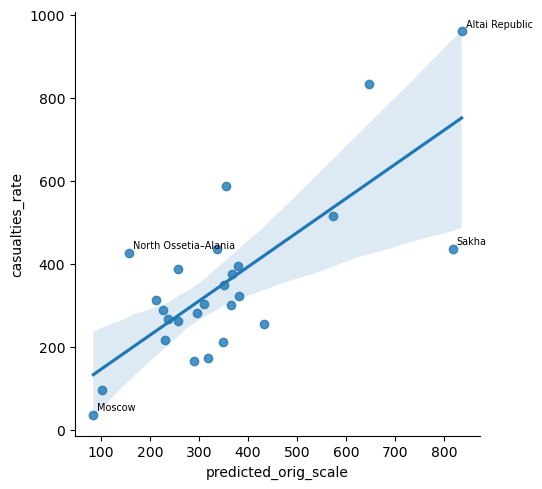

In [53]:
h = sns.lmplot(data = true_and_predicted, x = "predicted_orig_scale", y = "casualties_rate")

influential_regions = ["Altai Republic", "Sakha", "North Ossetia–Alania", "Moscow"]

for i, row in true_and_predicted.iterrows():
    if i in influential_regions:
        h.ax.annotate(str(i), xy = (row["predicted_orig_scale"], row["casualties_rate"]), xytext = (3, 3), textcoords = "offset points", fontsize = 7)

plt.show()

These influential regions belong to different classes: eliminating Altai Republic decreases the quality of predictions, while elimiating three other regions increases it. Thus, North Ossetia-Alania, Moscow and Sakha look like "outliers" which our model does not capture well. In fact, according to our model, Sakha and Altai Republic are practically identical, but in reality their casualty rates are very different. If our model could better differentiate between these two cases, its performance would likely improve. Although the regression line is roughly equidistant from both Sakha and the Altai Republic, the latter is situated closely to the line connecting it to Chukotka Autonomous Okrug, whereas Sakha stands out as a true outlier.

Overall, we might say that the influence of these three cases on the model performance is significant and noticeable, but hardly dramatic: our sample is very small (less than 30 observations), but eliminating any of these regions results in a drop in the model's quality of no more than 7-9%.  

Still, It is worth considering briefly each of these cases. Moscow is an exception from the general rule established by our model because of its remarkably low (in the comparative perspective) casualty rate. This can be attributed to a wide range of factors, as Moscow is very different from other regions — except possibly for Saint Petersburg — in terms of various socio-economic characteristics.  It also might be important that Moscow has an especially important political status, and high mobilization rates could lead to grievances which Russian government obviously tries to avoid. In this sense, Moscow is a "separate world" during this war, with the political establishment making considerable efforts to minimize the perception among Moscow residents that Russia is engaged in a full-blown war [[2]](https://republic.ru/posts/106722).

North Ossetia is an exception from the general tendency observed in the Caucasian republics: in North Ossetia, casualty rate is unusually high for this region. The reasons behind this pattern are not totally clear; it could be that our model does not adequately account for the socio-economic factors involved, or there may be cultural influences at play. For instance, in contrast to most other Caucasian republics of Russia (except for Adygea), Islam is not the largest confession in North Issetia, with approximately 50% of the population identifying as Orthodox Christians [[3]](https://en.wikipedia.org/wiki/Islam_in_Russia#Islam_in_Russia_by_region). 

It is perhaps even more difficult to understand why the predictions for Sakha are significantly higher than the actual casualty rate. To investigate the factors driving these inflated predictions, we can use the SHAP method.

In [54]:
# Initializing SHAP for our model and data
def model_predict(X):
    return svr_tuned.predict(X)

explainer = shap.Explainer(model_predict, predictors_fin_test)
shap_values = explainer(predictors_fin_test)
shap.initjs()

ExactExplainer explainer: 27it [00:17,  1.51it/s]                                                                      


It is interesting to investigate which factors drive the results for all our "outliers", not only Sakha.

North Ossetia–Alania:


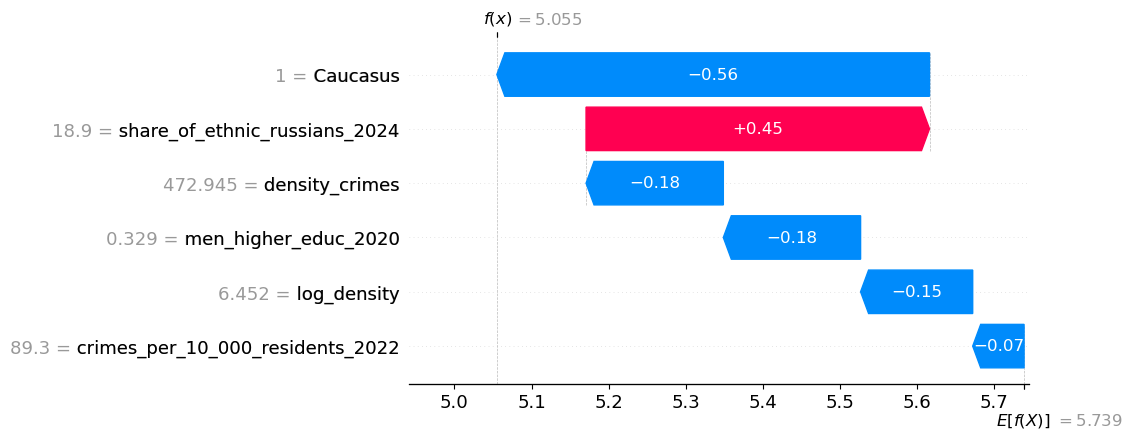

Moscow:


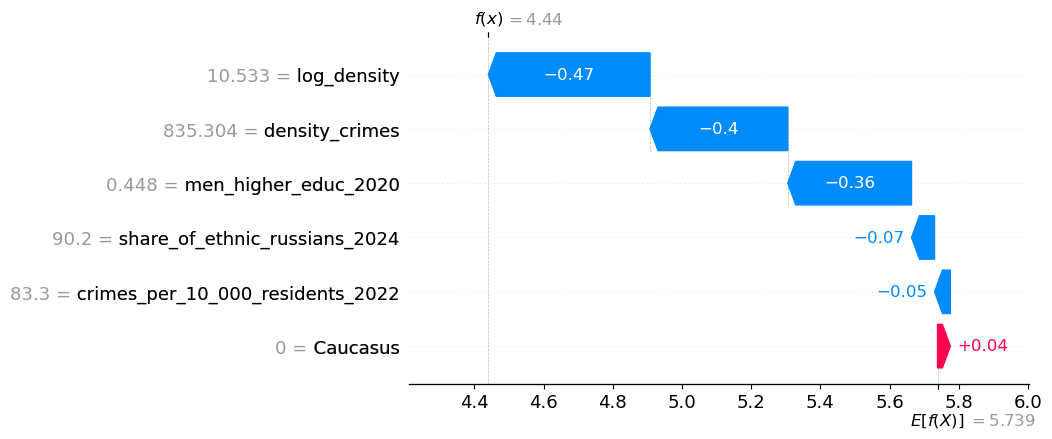

Sakha:


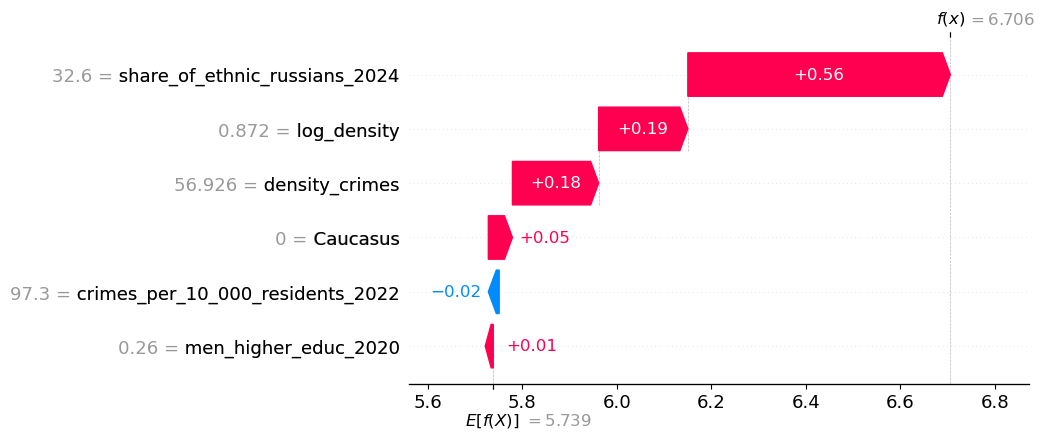

In [55]:
# Identifying indices of our "outliers"
test_indices = predictors_fin_test.reset_index().copy()
test_indices.index.name = "index"
outliers = ["North Ossetia–Alania", "Moscow", "Sakha"]
idx_outliers = [idx for region in outliers for idx in test_indices.index[test_indices["region_in_English"] == region]]

# SHAP waterfall plot for "outliers"
for i, region in zip(idx_outliers, outliers):
    print(f"{region}:")
    shap.waterfall_plot(shap_values[i])

As we may see, the model's prediction for Moscow is very low and it is pushed down by every single feature (except for small positive influence of "Caucasus" feature). In reality, the prediction should be even lower, highlighting Moscow's unique position in the "war landscape" of Russia.

For North Ossetia-Alania, the prediction is strongly affected by the "Caucasus" feature, but this influence distorts the reality in this particular case. The question of why this is the case remains, but it is not addressed in this project, although it is an intriguing topic to consider.

The case of Sakha is perhaps the least clear. The main factor contributing to the too high prediciton is the (relatively low) share of the ethnically Russian population. This in itself is a reflection of a peculiar pattern: casualty rates per 100 000 men tend to be higher, ceteris paribus, in regions with a comparatively low share of ethnically Russian population. As discussed previously, this pattern does not seem to indicate any real causal relationships; instead, it serves as a proxy for other factors. These may include elements of the imperial or quasi-imperial logic in Russian recruitment policies or the distribution of positions within the Russian army (on this topic, see the [paper](https://www.tandfonline.com/doi/full/10.1080/1060586X.2025.2484150) by Driscoll et al.). Though such factors appear to have explanatory force for many other regions, Sakha, for some reasons, does not fully conform to these patterns (provided that our data is largely accurate in the first place).

Overall, these outliers, particularly Sakha, indicate that, while our model is relatively successful in statistical sense, it is substantively limited. It would be overly presumptuous to claim that it reveals a "causal mechanism" behind casualty rates across Russian regions. As mentioned at the beginning of this analysis, several features highlighted by the final model — such as the proportion of the ethnically Russian population, the "Caucasus" feature, and the logarithm of population density — do not have self-sufficient explanatory power. They likely serve as proxies for other unobserved factors that may have a genuine causal effect. Some of these possible factors were hinted to above.

It is intriguing to explore whether the features in our model have similar effects across our sample. Since SVR does not permit direct evaluation of coefficients, we can employ the SHAP method once again. Let’s randomly select 10 observations and examine the patterns to understand how the features influence the predictions.

Orenburg Oblast:


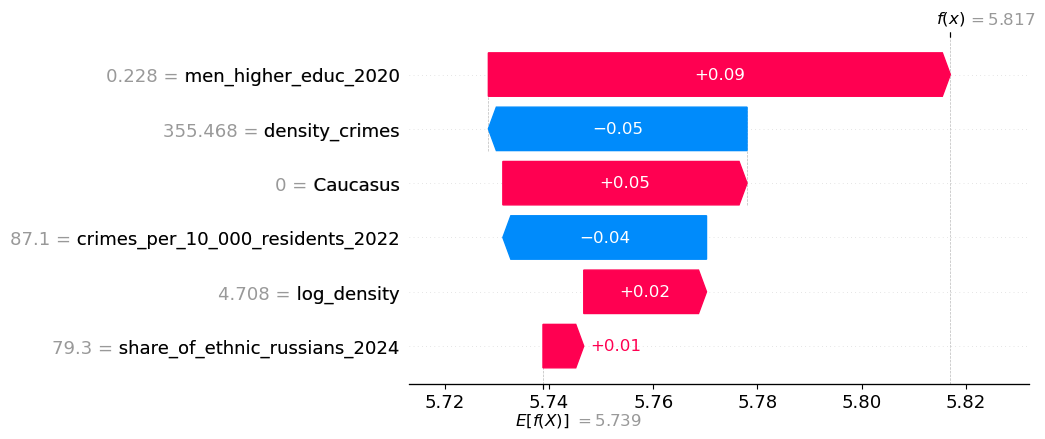

Leningrad Oblast:


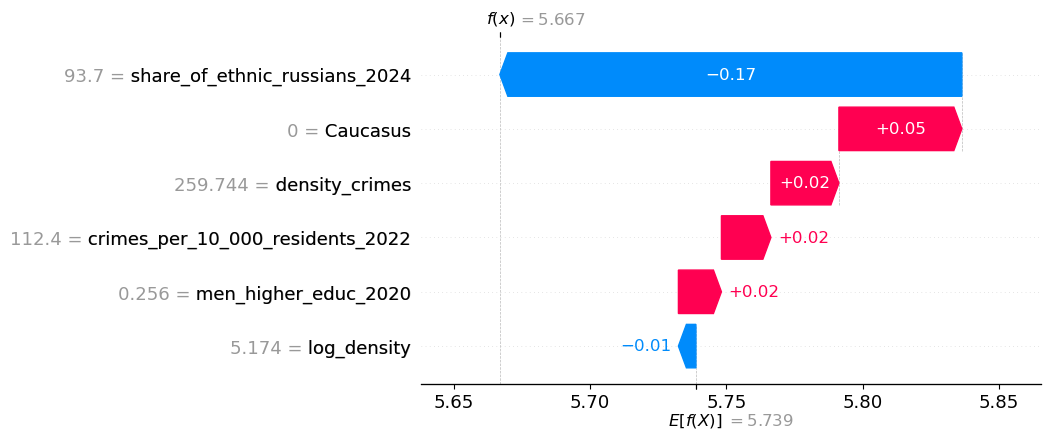

Smolensk Oblast:


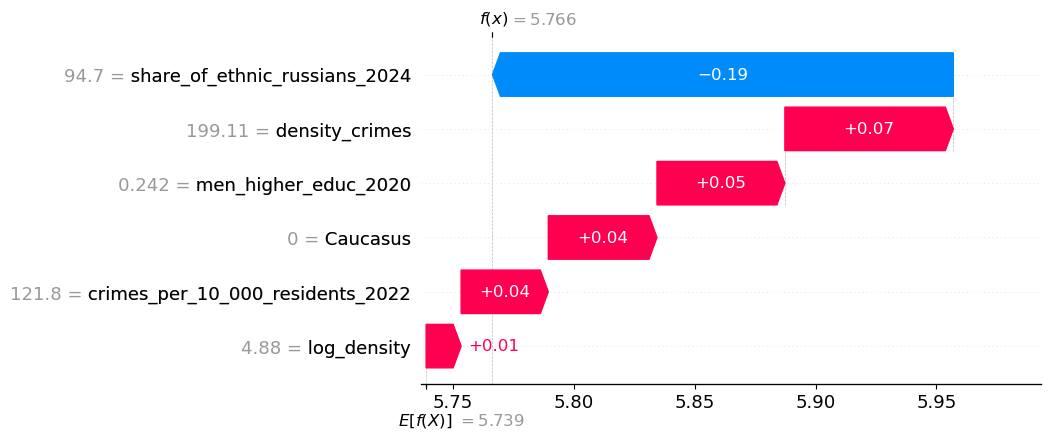

Oryol Oblast:


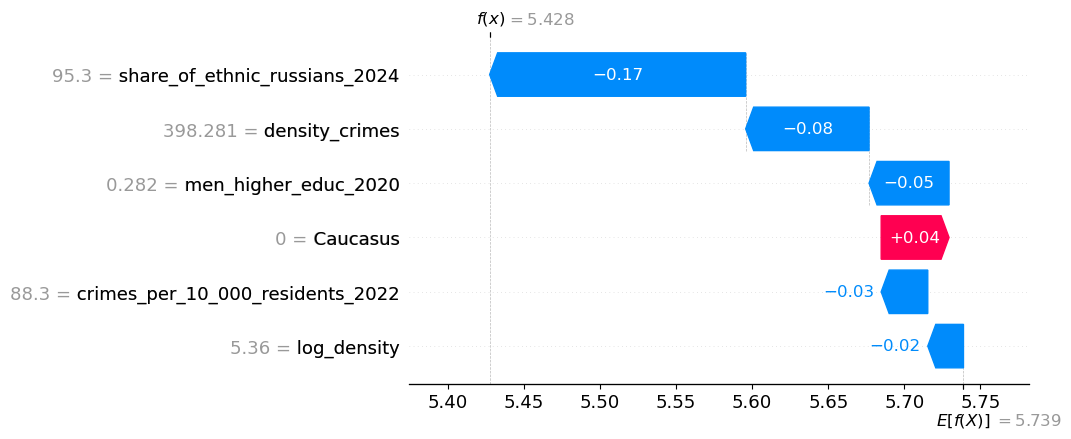

Yamalo-Nenets Autonomous Okrug:


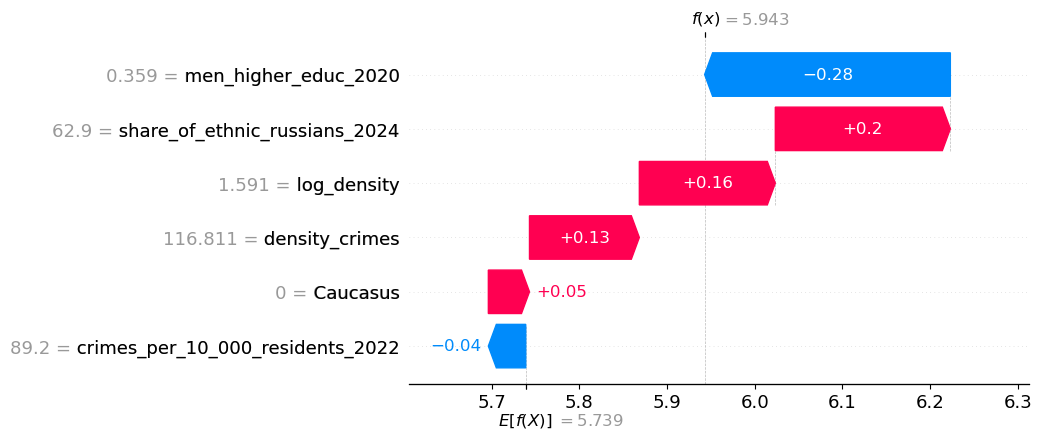

Ivanovo Oblast:


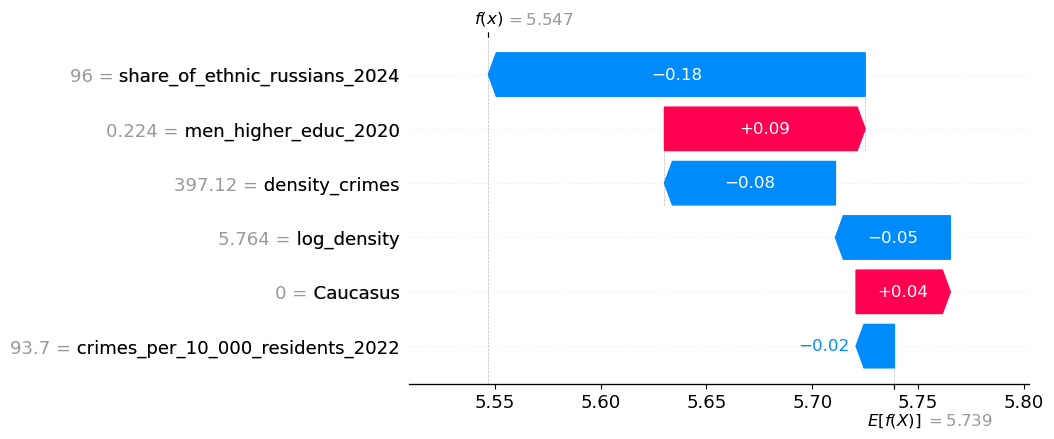

Jewish Autonomous Oblast:


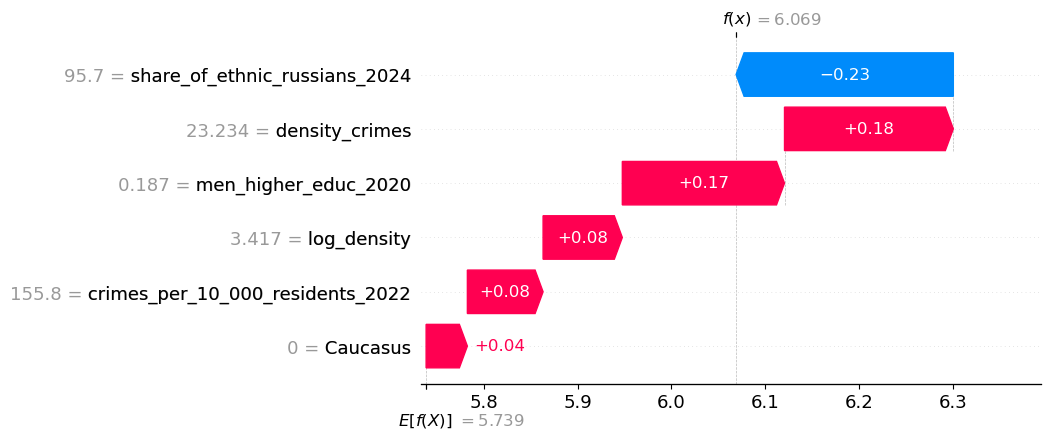

Komi Republic:


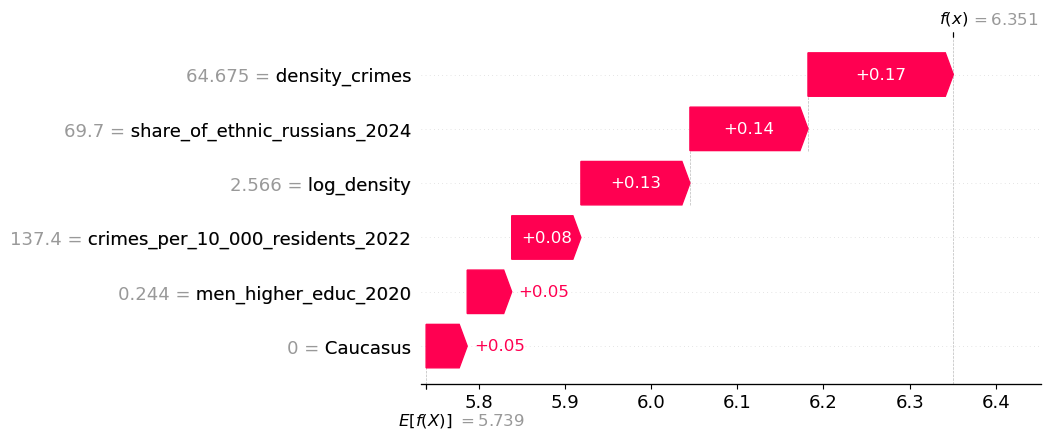

Primorsky Krai:


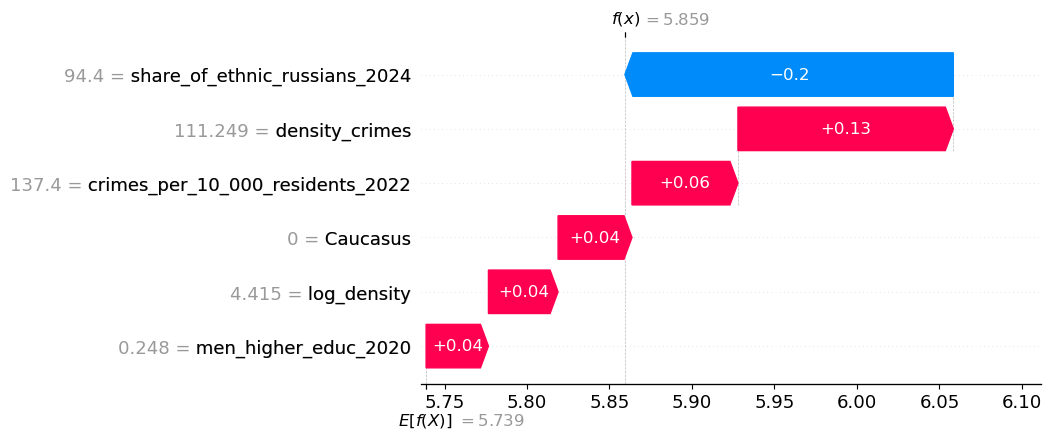

Ingushetia:


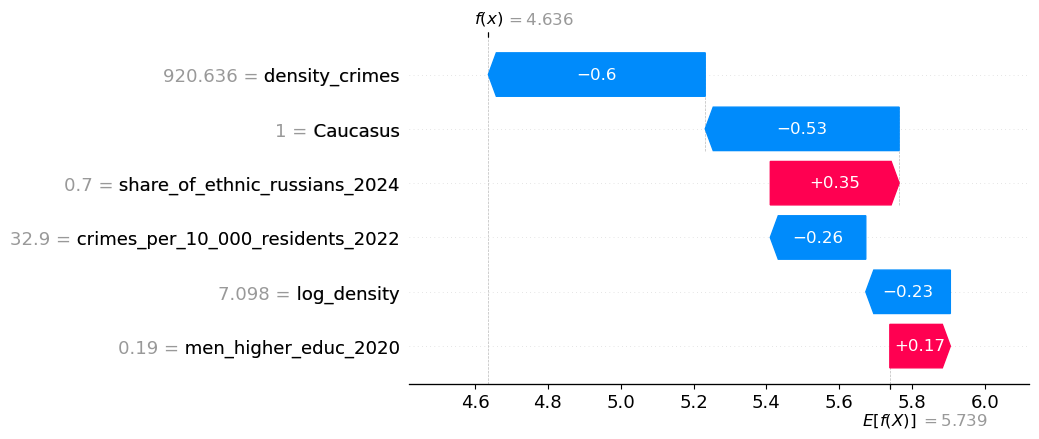

In [56]:
# SHAP waterfall plots for 10 randomly selected regions
random.seed(42)
ten_random_regions = random.sample(predictors_fin_test.index.to_list(), 10)
idx_random_regions = [idx for region in ten_random_regions for idx in test_indices.index[test_indices["region_in_English"] == region]]

# SHAP waterfall plot for "outliers"
for i, region in zip(idx_random_regions, ten_random_regions):
    print(f"{region}:")
    shap.waterfall_plot(shap_values[i])

In [57]:
# Descriptive statistics for the features
predictors_fin_test.describe().round(3)

,men_higher_educ_2020,density_crimes,log_density,crimes_per_10_000_residents_2022,Caucasus,share_of_ethnic_russians_2024
count,26.000,26.000,26.000,26.000,26.000,26.000
mean,0.263,280.046,4.588,107.215,0.077,77.250
std,0.056,228.248,2.146,27.281,0.272,26.207
min,0.187,-23.427,-0.712,32.900,0.000,0.700
25%,0.226,123.793,3.627,89.500,0.000,67.750
50%,0.253,240.558,4.818,99.600,0.000,91.900
75%,0.283,392.797,5.529,128.575,0.000,94.625
max,0.448,920.636,10.533,161.600,1.000,96.000


Comparing the data from SHAP waterfall plots with the descriptive statistics above, we may notice that, indeed, the model exhibits some consistent patterns:
* A relatively high rate of higher education among men tends to be negatively associated with the casualty rate.
* Interpreting the effects of the "density_crimes" interaction term is challenging without explicitly provided coefficients. However, we observe in the plots above that the logic of its association with the target variable is the same as that of the "original" variables from which it is derived. As previously discussed, population density serves as a proxy for potential causal factors such as the level of political significance for the federal government, the administrative capabilities of local authorities to carry out coercive mobilization, and the capacity of civil society to organize resistance against mobilization efforts. Crime rates, on the other hand, purport to be a proxy for the general well-being in the region. The interaction term "density_crimes" is thus a variable aiming at capturing the intersection between these factors (associated with coercive mobilization and volunteer consription, in terms of our previous discussion). In sum, as "density_crimes" and population density increase, casualty rates tend to decrease; conversely, higher crime rates are associated with increased casualty rates. 
* Both the "Caucasus" feature and the higher percentage of ethnically Russian population tend to be associated with the lower casualty rates.

Is it possible to extract some general lessons from our model, given its limitations noted above?

I believe the answer is more positive than negative. Below, I sumarize the key takeaways of the preceding analysis.

### Lesson 1. The intertwinement of the political and socio-economic logics within Russian recruitment policies

Perhaps the most general takeaway from the above analysis is that the patterns of casualties across Russian regions are indeed complex; they likely result from intricate intersections and interactions of various factors. 

Our analysis bolsters the hypothesis that both political and socio-economic logics are involved. To simplify the conceptual structure of  discussion, I associated political factors with coercive mobilization component of the Russian recruitment policy, whereas socio-economic factors might be especially pronounced for the other recruitment channel - volunteer conscription with substantive material incentives. The population density and the share of ethnically Russian population variables purport to reflect some elements of the political logic, whereas crime rates and the share of men with higher education aim to caprure relevant socio-economic characteristics. Crime rates, howerver, might be relevant for some peculiar practices of coercive mobilization as well, namely "direct" mobilization from prisons. There is some evidence that prisoners from ethnic minorities are particularly vulnerable to this form of coercive mobilization. ([[4]](https://www.rferl.org/a/russia-war-ukraine-inmates-concsripts-ethnic-minorities-coersion-rights-romanova/33492747.html)).

### Lesson 2. The intertwinement of general and local, contextual factors

The apparent significance of the "Caucasus" feature supports the conjecture that purely contextual factors might be important. Perhaps certain traits of Caucasian societies, such as their tight-knit social networks, could make Caucasian men less responsive to the individual incentives to participate in war; perhaps recent political history makes Russian government oversensitive to public sentiment in the Caucasus region, and this affects the political logic of rectuitment efforts in this region; perhaps Caucasian society (once again, thanks to tight social networks) is especially capable of resistance against mobilization efforts (protests in Dagestan were perhaps the most significant in the active phase of coercive mobilization). The precise reasons remain unclear, but our model indicates that Caucasian republics do not fully align with general patterns observed elsewhere.     

### Lesson 3. Economic conditions as such do not explain recruitment rates patterns

Interestingly, the most obvious economic variables, such as poverty level or (adjusted) average salary, have not exhibited sufficient explanatory power to be included in our final model. This is noteworthy because it is natural to regard these factors as the primary drivers within the socio-economic logic of recruitment. Indeed, there has been some debates as to whether such factors are able to account for observed patterns ([[5]](https://ore.exeter.ac.uk/repository/handle/10871/133317), [[6]](https://russiapost.info/society/targeting_ethnic_minorities)). Our model suggests a potential resolution to this issue: what may be particularly relevant in terms of socio-economic characteristics are not the economic conditions themselves but their intersection with social parameters (perhaps the presence of sufficiently developed networks of social support) and susceptibility to the state propaganda. The probable importance of social parameters is hinted at by our "Caucasus" feature (an economically disadvantaged region, albeit with relatively strong elements of traditional society) and crime rates, whereas the significance of the share of men with higher education supports the second proposition. 

### Lesson 4. Regions with a substantial share of ethnic minorities appear to be disproportionally affected

One of the most concerning and politically sensitive findings from the analysis is linked to the ethnic composition of regional populations. Our model indicates that regions with a higher percentage of ethnic minorities tend to experience higher casualty rates. 

A very important caveat is that the preceding analysis did not take into account the actual ethnicity of soldiers but was conducted on the regional level. This distinction may be significant, because there is research suggesting that ethnicity as such is not an explanatory factor of casualty rates in this war ([[7]](https://ore.exeter.ac.uk/repository/handle/10871/133317)). However, there is also plenty of evidence to the contrary ([[8]](https://brill.com/view/journals/inas/25/1/article-p126_11.xml#FN000009), [[9]](https://www.themoscowtimes.com/2022/09/27/ethnic-minorities-hit-hardest-by-russias-mobilization-activists-say-a78879)). 

In any case, it would be more reasonable to adopt a cautious interpretation of our findings, framing them in terms of regions with a substantial share of ethnic minorities rather than in terms of ethnic groups as such. Still, even this formulation raises questions about the underlying reasons for the observed patterns (assuming our model is reliable in this respect). As discussed earlier, these patterns may reflect some form of "imperial" logic influencing Russian recruitment policy. 

Another suggested explanation points to the presence of large military bases in near-border regions with high levels of ethnic minorities ([[10]](https://brill.com/view/journals/inas/25/1/article-p126_11.xml#FN000009)). However, if consider the sheer number of military bases across regions [[11]](https://en.wikipedia.org/wiki/List_of_Russian_military_bases), there does not appear to be a strong correlation with casualty rates. For instance, there are many bases in Moscow Oblast and Leningrad Oblast, both of which have low casualty rates; there are bases in other regions with low casualty rates, such as Chechnya, Amur Oblast, Nizhny Novgorod Oblast, etc. At the very least, the presence of military bases has to be combined with some other factors to serve as a reasonable explanatory variable; but, once again, the share of ethnic minorities in the regional population is the best candidate for such a factor.

***

Overall, when considering both political and socio-economic factors, it appears that the Russia-Ukraine war disproportionately affects the more vulnerable social strata — groups with fewer resources and types of capital (economic, social, symbolic). These groups ultimately become another victim of the war. If this observation is accurate, it highlights an  easily overlooked aspect of the tragic nature of this war.